In [1]:
"""
Predict albedo and shading layer of an input image.
"""

import os
import sys
sys.path.append('./util')
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

__author__ = "Udo Dehm"
__copyright__ = "Copyright 2017"
__credits__ = ["Udo Dehm"]
__license__ = ""
__version__ = "0.1"
__maintainer__ = "Udo Dehm"
__email__ = "udo.dehm@mailbox.org"
__status__ = "Development"

In [2]:
def import_data(data_directory):
    dfs_train = {}
    dfs_valid = {}
    for file in os.listdir(data_directory):
        df_name = 'df_' + file[10:-4].replace('loss_', '').replace('_1', '').replace('invariant', 'inv')
        if 'valid' in file:
            df_name = df_name.replace('valid_', '')
            dfs_valid[df_name] = pd.read_csv(filepath_or_buffer=data_directory + file)
            dfs_valid[df_name].columns = dfs_valid[df_name].columns.str.replace(" ", "_").str.lower()
            dfs_valid[df_name]['wall_time'] = pd.to_datetime(dfs_valid[df_name]['wall_time'],unit='s')
        else:
            df_name = df_name.replace('_loss', '')
            if '_lambda' in df_name:
                df_name = df_name[:df_name.find('_lambda')]
            dfs_train[df_name] = pd.read_csv(filepath_or_buffer=data_directory + file)
            dfs_train[df_name].columns = dfs_train[df_name].columns.str.replace(" ", "_").str.lower()
            dfs_train[df_name]['wall_time'] = pd.to_datetime(dfs_train[df_name]['wall_time'],unit='s')
    return dfs_train, dfs_valid


def plot_all_loss_pairs(dfs_train, dfs_valid, logy=False, ylim_scale=5):
    for key in dfs_train:
        fig = plt.figure
        ax = dfs_train[key].plot(x='step', y='value', figsize=(12,7), 
                                 fontsize=14, legend=True, style='-o',
                                 title=key[3:], logy=logy)
        dfs_valid[key].plot(x='step', y='value', style='-o', ax=ax)
        ax.set_xlabel('step')
        ax.set_ylabel('loss')
        plt.ylim(0,ylim_scale*dfs_train[key]['value'].max())
        ax.legend(["training set", "validation set"], prop={'size': 14})
        # plt.savefig('foo.png', bbox_inches='tight')


def get_all_loss_model_data(data_dir, exclude_sub_dirs=[]):
    dfs_train = {}
    dfs_valid = {}
    dirs = [x for x in sorted(os.listdir(data_dir)) if x not in exclude_sub_dirs]
    for direc in dirs:
        dict_train, dict_valid = import_data(data_directory=data_dir + '/' + direc + '/')
        for key in dict_train:
            if key not in dfs_train:
                dfs_train[key] = pd.DataFrame()
                dfs_valid[key] = pd.DataFrame()
            dfs_train[key] = dfs_train[key].append(dict_train[key], ignore_index=True)
            dfs_valid[key] = dfs_valid[key].append(dict_valid[key], ignore_index=True)
    return dfs_train, dfs_valid


def get_minimum_loss(dfdict_train, dfdict_valid):
    print('Training loss:')
    dict_return_steps = {}
    dict_return_minloss = {}
    dict_return_cor_val_tr_step = {}
    dict_return_cor_val_tr_loss = {}
    for key, df in dfdict_train.items():
        minstep = df.loc[df['value'].idxmin(),'step']
        cor_valloss = dfdict_valid[key].loc[(dfdict_valid[key]['step'] - minstep).abs().idxmin()][['step', 'value']]
        print('{dfname} (step: {step}): {minloss:.5f} <-> corresponding valid loss: {valloss:.5f} (step: {valstep})'.format(dfname=key,
                                                              minloss=df['value'].min(),
                                                              step=minstep,
                                                              valloss=cor_valloss['value'],
                                                              valstep=cor_valloss['step']))
        dict_return_steps[key] = minstep
        dict_return_minloss[key] = df['value'].min()
        dict_return_cor_val_tr_step[key] = cor_valloss['step']
        dict_return_cor_val_tr_loss[key] = cor_valloss['value']
    dict_return = {}
    dict_return[('training', 'step')] = dict_return_steps
    dict_return[('training', 'minimum_loss')] = dict_return_minloss
    dict_return[('training', 'cor_val_tr_step')] = dict_return_cor_val_tr_step
    dict_return[('training', 'cor_val_tr_loss')] = dict_return_cor_val_tr_loss
        
        
    print('\nValidation loss:')
    dict_return_steps = {}
    dict_return_minloss = {}
    dict_return_cor_val_tr_step = {}
    dict_return_cor_val_tr_loss = {}
    for key, df in dfdict_valid.items():
        minstep = df.loc[df['value'].idxmin(),'step']
        cor_trainloss = dfdict_train[key].loc[(dfdict_train[key]['step'] - minstep).abs().idxmin()][['step', 'value']]
        print('{dfname} (step: {step}): {minloss:.5f} <-> corresponding train loss: {trainloss:.5f} (step: {trainstep})'.format(dfname=key,
                                                              minloss=df['value'].min(),
                                                              step=minstep,
                                                              trainloss=cor_trainloss['value'],
                                                              trainstep=cor_trainloss['step']))
        dict_return_steps[key] = minstep
        dict_return_minloss[key] = df['value'].min()
        dict_return_cor_val_tr_step[key] = cor_trainloss['step']
        dict_return_cor_val_tr_loss[key] = cor_trainloss['value']
    dict_return[('validation', 'step')] = dict_return_steps
    dict_return[('validation', 'minimum_loss')] = dict_return_minloss
    dict_return[('validation', 'cor_val_tr_step')] = dict_return_cor_val_tr_step
    dict_return[('validation', 'cor_val_tr_loss')] = dict_return_cor_val_tr_loss

    return pd.DataFrame(dict_return)

In [3]:
logs_data_path = '/home/udo/image_decomposition/logs/logs_data/'

# Sintel:

In [4]:
logs_data_path_sintel = logs_data_path + 'sintel/'

## Resnet-50 narihira2015 (2 scale, reduced parameters):

Training loss:
df_l2_inv (step: 25800): 0.00151 <-> corresponding valid loss: 0.02111 (step: 25800)
df_l1 (step: 21400): 0.04206 <-> corresponding valid loss: 0.28019 (step: 21414)
df_l2 (step: 25800): 0.00248 <-> corresponding valid loss: 0.05663 (step: 25800)
df_l2_avg (step: 25800): 0.00199 <-> corresponding valid loss: 0.03887 (step: 25800)
df_berhu (step: 21400): 0.04235 <-> corresponding valid loss: 0.30654 (step: 21414)

Validation loss:
df_l2_inv (step: 4300): 0.02035 <-> corresponding train loss: 0.00400 (step: 4300)
df_l1 (step: 4300): 0.25791 <-> corresponding train loss: 0.07706 (step: 4300)
df_l2 (step: 4300): 0.05532 <-> corresponding train loss: 0.00699 (step: 4300)
df_l2_avg (step: 4300): 0.03783 <-> corresponding train loss: 0.00550 (step: 4300)
df_berhu (step: 4300): 0.28354 <-> corresponding train loss: 0.07787 (step: 4300)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


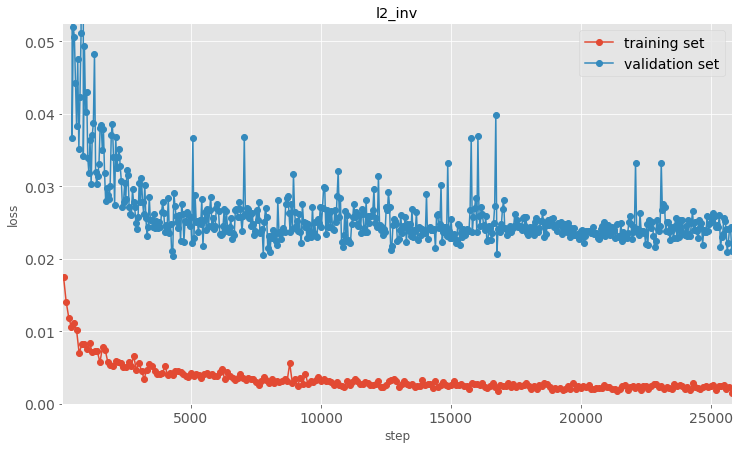

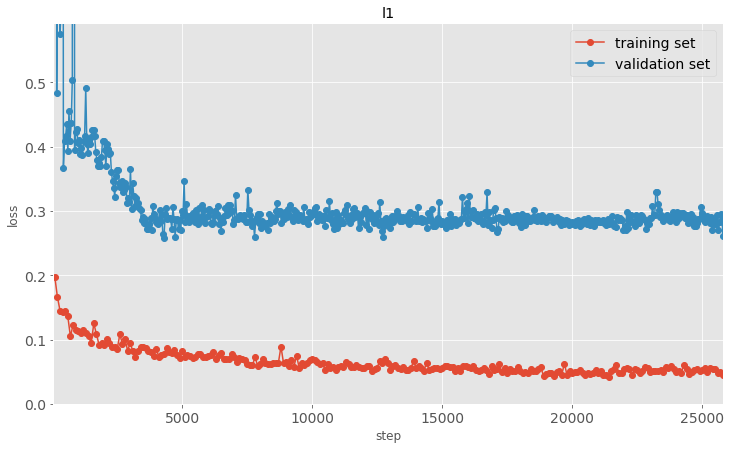

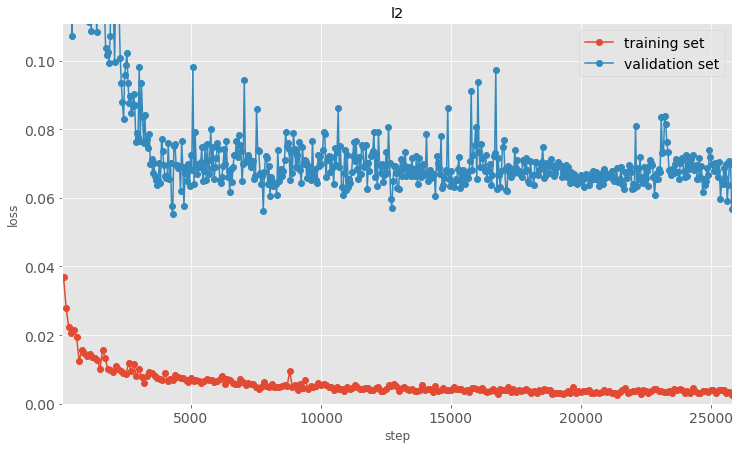

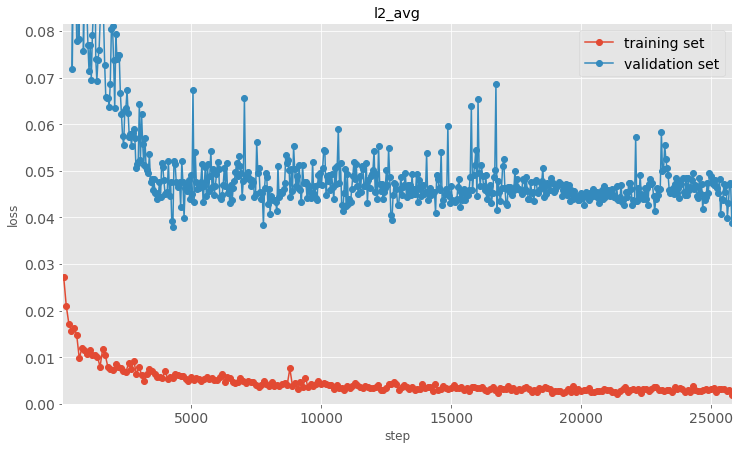

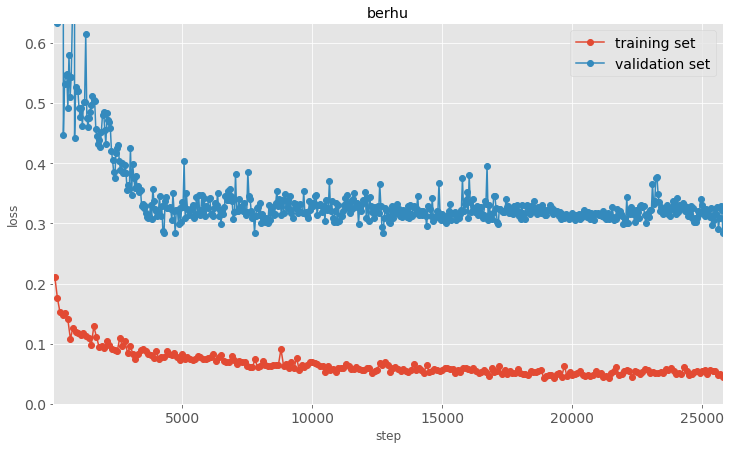

In [5]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_resnet_v1_50_narihira2015_reduced')
dfs_train_resnet_v1_50_narihira2015_reduced, dfs_valid_resnet_v1_50_narihira2015_reduced = lst

df_minloss_res_nari = get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_narihira2015_reduced,
                                       dfdict_valid=dfs_valid_resnet_v1_50_narihira2015_reduced)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_narihira2015_reduced, 
                    dfs_valid=dfs_valid_resnet_v1_50_narihira2015_reduced, logy=False, ylim_scale=3)

## Resnet-50 up-projection:

Training loss:
df_l2_inv (step: 12900): 0.87184 <-> corresponding valid loss: 4.02539 (step: 12900)
df_l1 (step: 10900): 0.06709 <-> corresponding valid loss: 0.37369 (step: 10879)
df_l2 (step: 12900): 0.87459 <-> corresponding valid loss: 4.07311 (step: 12900)
df_l2_avg (step: 12900): 0.87322 <-> corresponding valid loss: 4.04925 (step: 12900)
df_berhu (step: 10900): 0.06876 <-> corresponding valid loss: 0.40499 (step: 10879)

Validation loss:
df_l2_inv (step: 4042): 0.02324 <-> corresponding train loss: 1.60355 (step: 4000)
df_l1 (step: 3784): 0.29271 <-> corresponding train loss: 0.14983 (step: 3800)
df_l2 (step: 10449): 0.07115 <-> corresponding train loss: 1.06115 (step: 10400)
df_l2_avg (step: 4042): 0.04834 <-> corresponding train loss: 1.60768 (step: 4000)
df_berhu (step: 10621): 0.31395 <-> corresponding train loss: 0.08260 (step: 10600)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


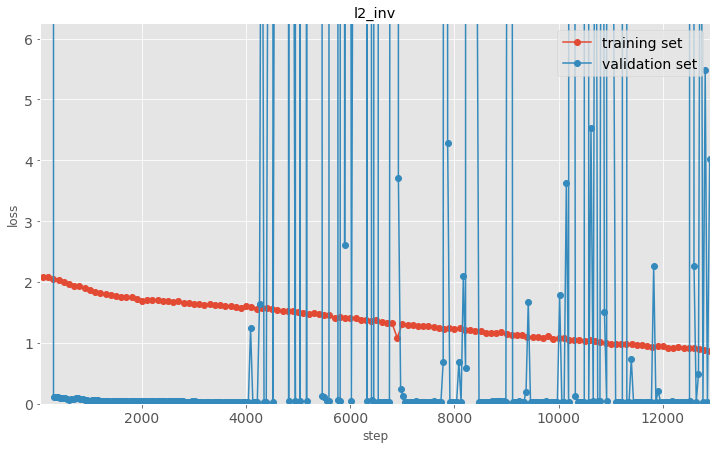

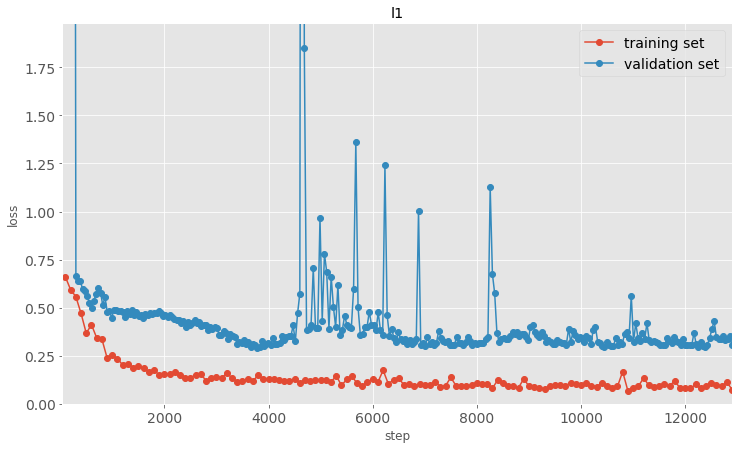

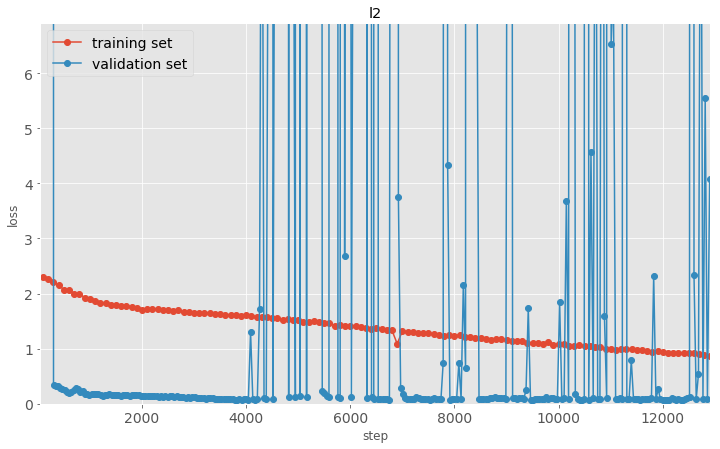

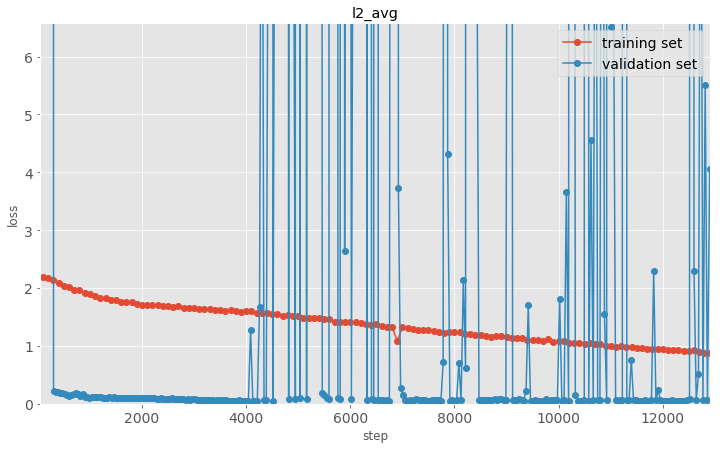

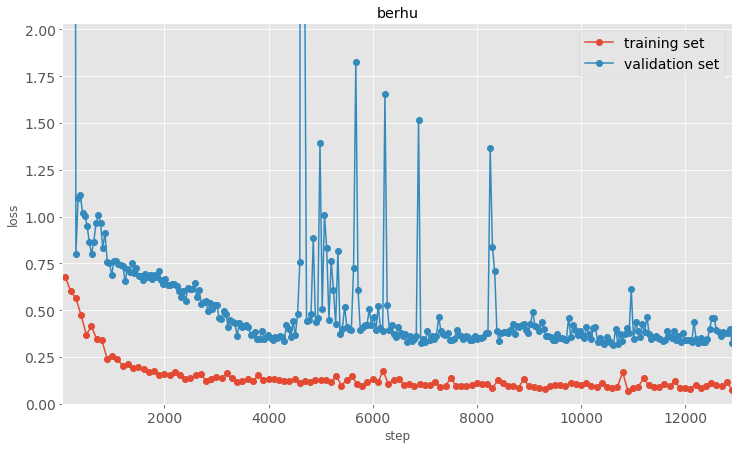

In [6]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_resnet_v1_50_up_projection')
dfs_train_resnet_v1_50_deconv_decoder_reduced, dfs_valid_resnet_v1_50_deconv_decoder_reduced = lst

df_minloss_res_upprojection = get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_deconv_decoder_reduced,
                                               dfdict_valid=dfs_valid_resnet_v1_50_deconv_decoder_reduced)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_deconv_decoder_reduced, 
                    dfs_valid=dfs_valid_resnet_v1_50_deconv_decoder_reduced, logy=False, ylim_scale=3)

## Resnet-50 deconv decoder (1 scale, reduced parameters):

Training loss:
df_l2_inv (step: 16600): 0.00432 <-> corresponding valid loss: 0.02397 (step: 16598)
df_l1 (step: 16600): 0.06813 <-> corresponding valid loss: 0.28823 (step: 16598)
df_l2 (step: 16600): 0.00664 <-> corresponding valid loss: 0.06720 (step: 16598)
df_l2_avg (step: 16600): 0.00548 <-> corresponding valid loss: 0.04558 (step: 16598)
df_berhu (step: 16600): 0.06963 <-> corresponding valid loss: 0.32215 (step: 16598)

Validation loss:
df_l2_inv (step: 14276): 0.02161 <-> corresponding train loss: 0.00647 (step: 14300)
df_l1 (step: 3999): 0.27212 <-> corresponding train loss: 0.10765 (step: 4000)
df_l2 (step: 14276): 0.06271 <-> corresponding train loss: 0.01011 (step: 14300)
df_l2_avg (step: 14276): 0.04216 <-> corresponding train loss: 0.00829 (step: 14300)
df_berhu (step: 17587): 0.28485 <-> corresponding train loss: 0.09452 (step: 17600)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


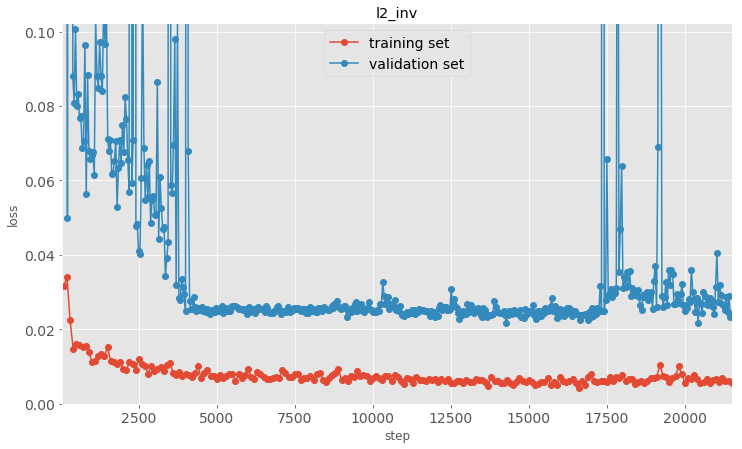

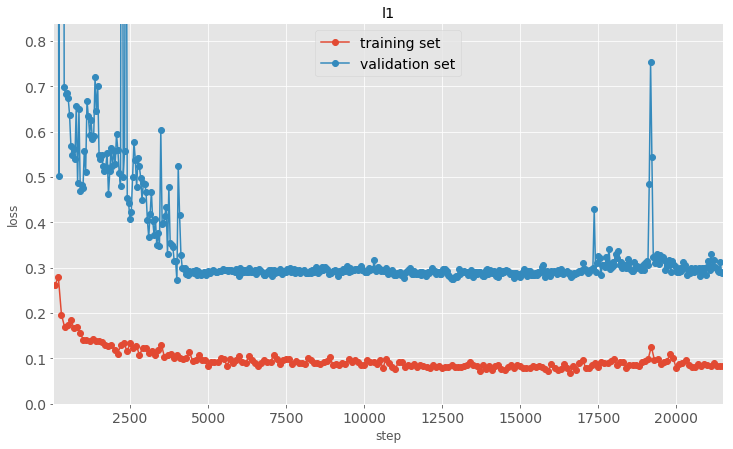

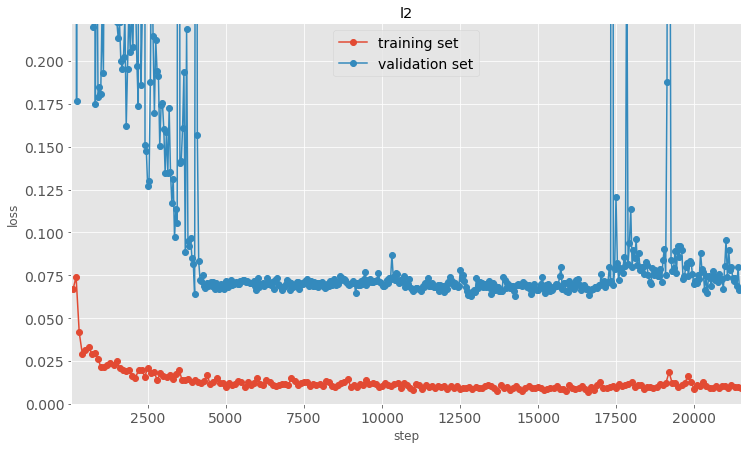

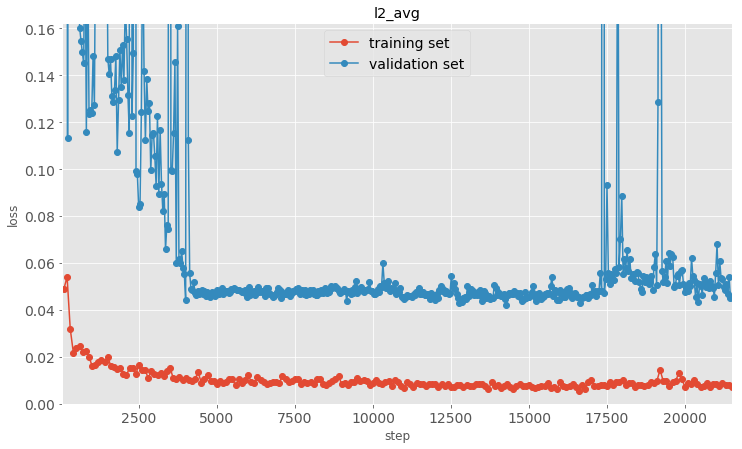

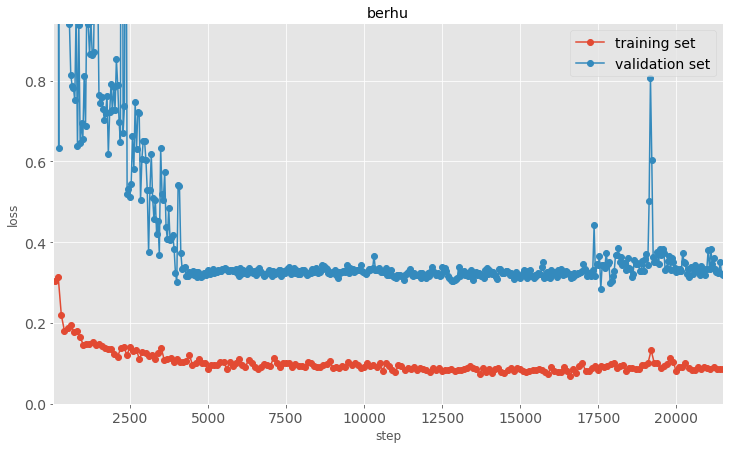

In [7]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_resnet_v1_50_deconv_decoder_reduced')
dfs_train_resnet_v1_50_deconv_decoder_reduced, dfs_valid_resnet_v1_50_deconv_decoder_reduced = lst

df_minloss_res_deconv = get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_deconv_decoder_reduced,
                                         dfdict_valid=dfs_valid_resnet_v1_50_deconv_decoder_reduced)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_deconv_decoder_reduced, 
                    dfs_valid=dfs_valid_resnet_v1_50_deconv_decoder_reduced, logy=False, ylim_scale=3)

## VGG-16 narihira2015 (2 scale, reduced parameters):

Training loss:
df_l2_inv (step: 12300): 0.00307 <-> corresponding valid loss: 0.03294 (step: 12298)
df_l1 (step: 12300): 0.06264 <-> corresponding valid loss: 0.31049 (step: 12298)
df_l2 (step: 12300): 0.00503 <-> corresponding valid loss: 0.08334 (step: 12298)
df_l2_avg (step: 12300): 0.00405 <-> corresponding valid loss: 0.05814 (step: 12298)
df_berhu (step: 12300): 0.06343 <-> corresponding valid loss: 0.35058 (step: 12298)

Validation loss:
df_l2_inv (step: 12771): 0.02963 <-> corresponding train loss: 0.00416 (step: 12800)
df_l1 (step: 12771): 0.28845 <-> corresponding train loss: 0.07636 (step: 12800)
df_l2 (step: 12771): 0.07305 <-> corresponding train loss: 0.00708 (step: 12800)
df_l2_avg (step: 12771): 0.05134 <-> corresponding train loss: 0.00562 (step: 12800)
df_berhu (step: 12771): 0.32275 <-> corresponding train loss: 0.07746 (step: 12800)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


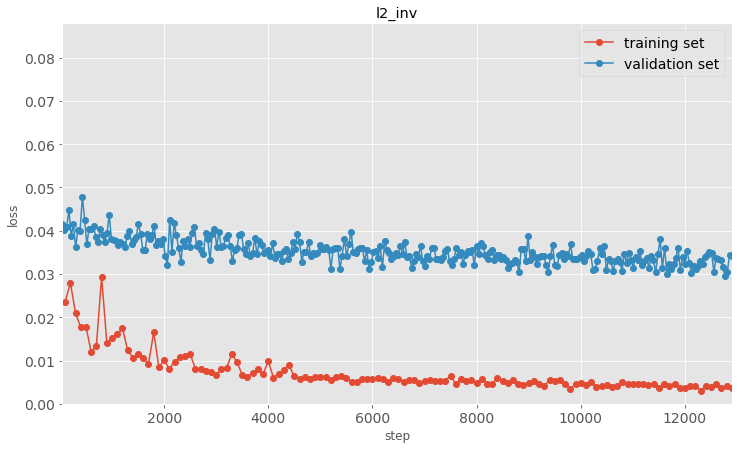

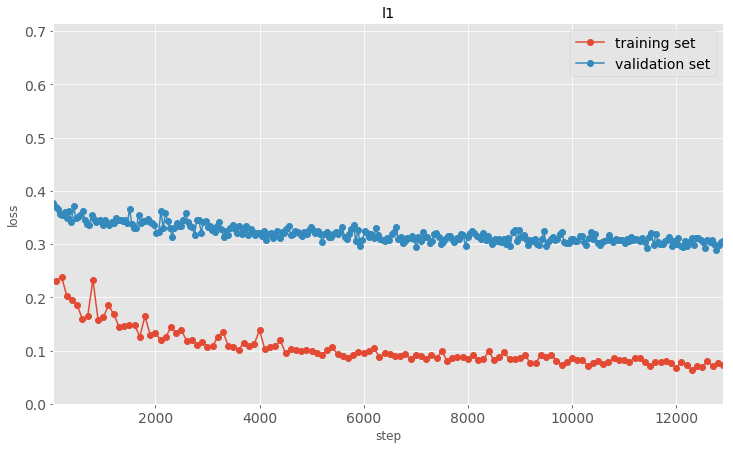

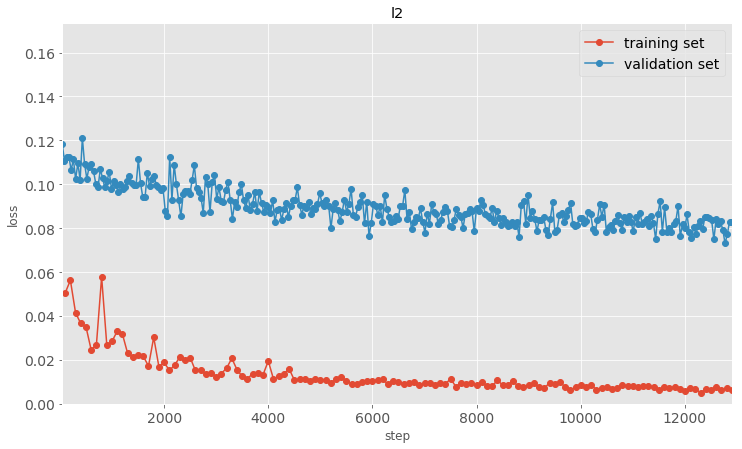

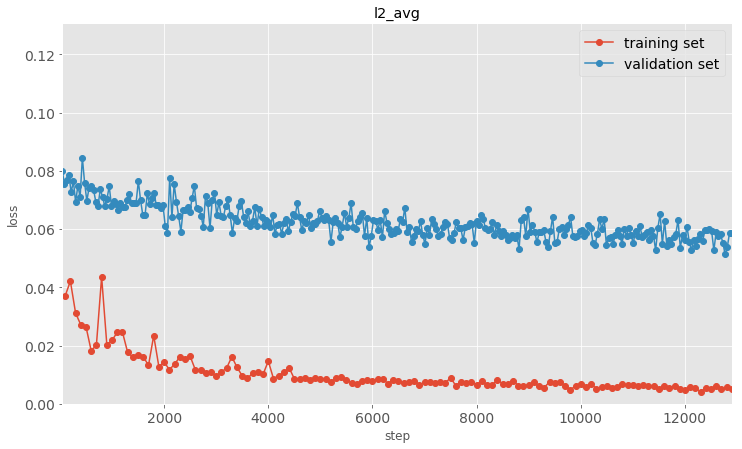

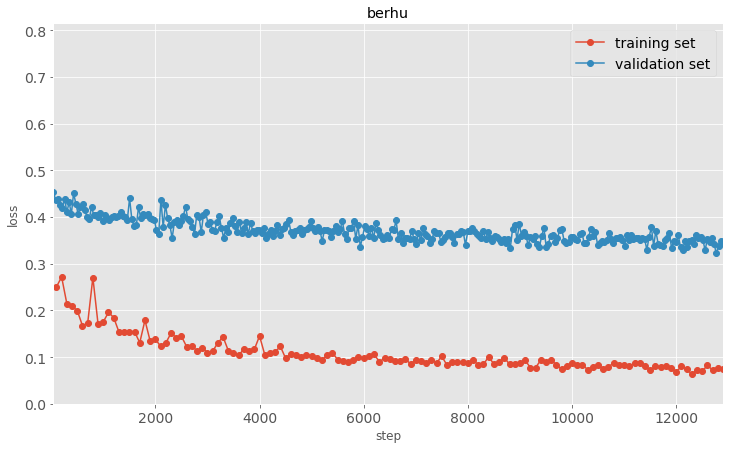

In [8]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_vgg16_narihira2015_reduced_bn')
dfs_train_vgg16_narihira2015_reduced_bn, dfs_valid_vgg16_narihira2015_reduced_bn = lst

df_minloss_vgg_nari = get_minimum_loss(dfdict_train=dfs_train_vgg16_narihira2015_reduced_bn,
                                       dfdict_valid=dfs_valid_vgg16_narihira2015_reduced_bn)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_narihira2015_reduced_bn, 
                    dfs_valid=dfs_valid_vgg16_narihira2015_reduced_bn, logy=False, ylim_scale=3)

## VGG-16 deconv decoder (1 scale, reduced parameters, bn):

Training loss:
df_l2_inv (step: 11400): 0.00690 <-> corresponding valid loss: 0.03120 (step: 11395)
df_l1 (step: 11400): 0.08655 <-> corresponding valid loss: 0.30151 (step: 11395)
df_l2 (step: 11400): 0.01065 <-> corresponding valid loss: 0.07859 (step: 11395)
df_l2_avg (step: 11400): 0.00877 <-> corresponding valid loss: 0.05490 (step: 11395)
df_berhu (step: 11400): 0.08974 <-> corresponding valid loss: 0.34865 (step: 11395)

Validation loss:
df_l2_inv (step: 8600): 0.02909 <-> corresponding train loss: 0.00873 (step: 8600)
df_l1 (step: 11481): 0.28914 <-> corresponding train loss: 0.09907 (step: 11500)
df_l2 (step: 11481): 0.07362 <-> corresponding train loss: 0.01302 (step: 11500)
df_l2_avg (step: 8600): 0.05149 <-> corresponding train loss: 0.01164 (step: 8600)
df_berhu (step: 8600): 0.33092 <-> corresponding train loss: 0.11232 (step: 8600)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


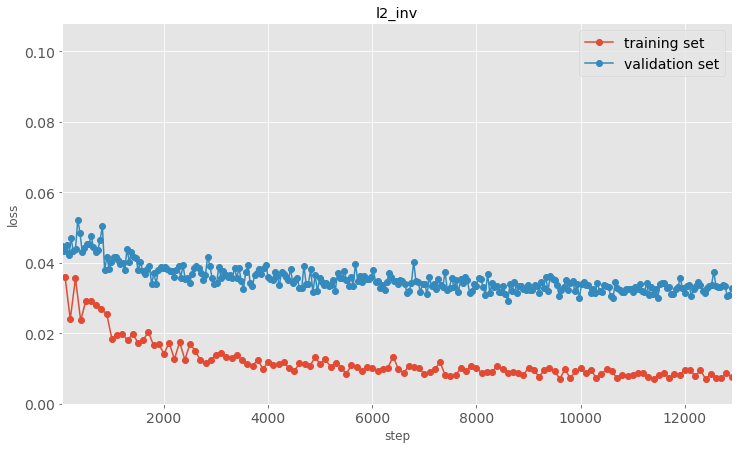

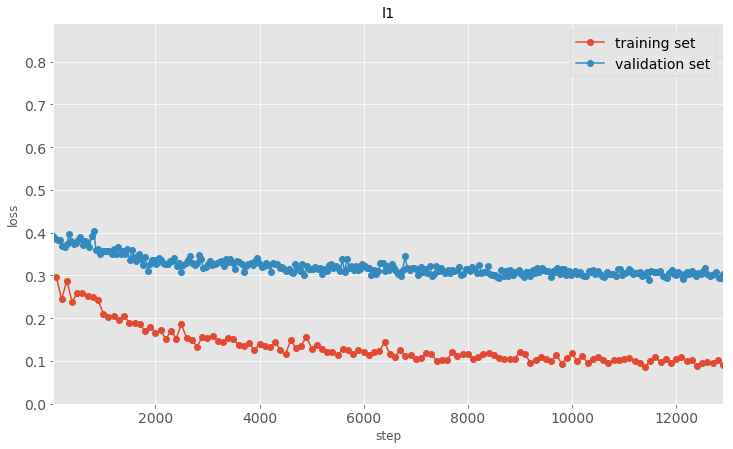

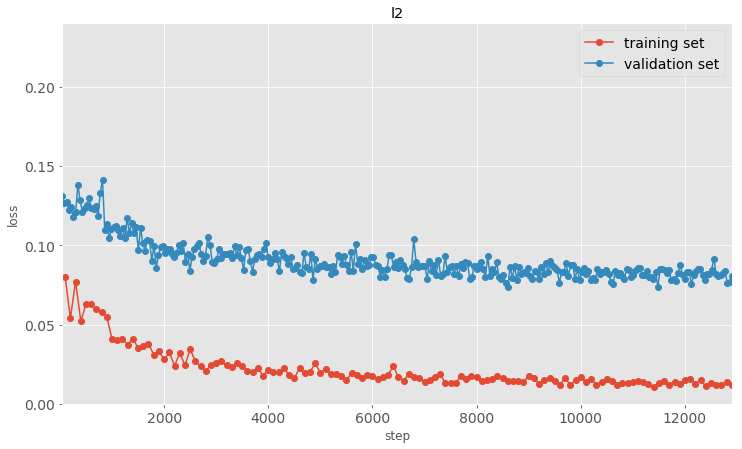

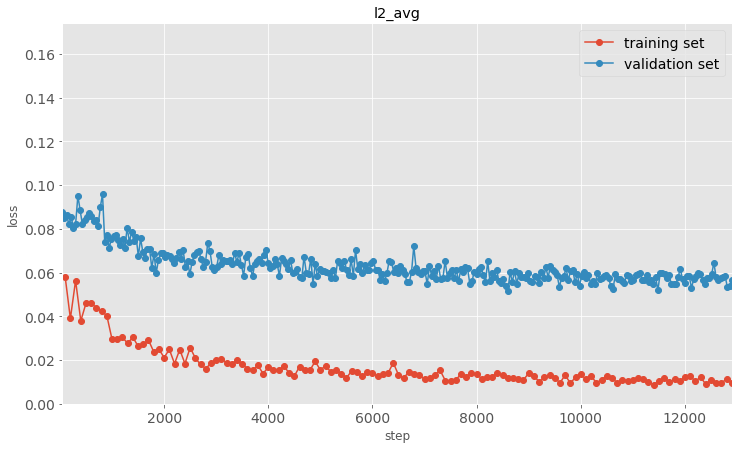

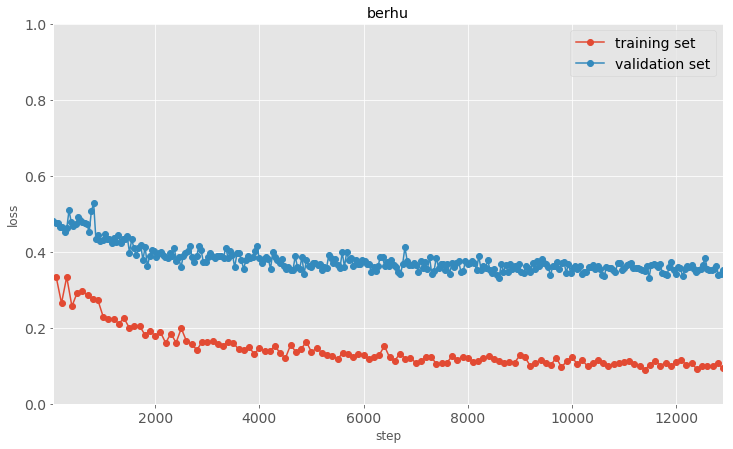

In [9]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_vgg16_deconv_decoder_reduced_bn')
dfs_train_vgg16_deconv_decoder_reduced_bn, dfs_valid_vgg16_deconv_decoder_reduced_bn = lst

df_minloss_vgg_deconv = get_minimum_loss(dfdict_train=dfs_train_vgg16_deconv_decoder_reduced_bn,
                                         dfdict_valid=dfs_valid_vgg16_deconv_decoder_reduced_bn)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_deconv_decoder_reduced_bn, 
                    dfs_valid=dfs_valid_vgg16_deconv_decoder_reduced_bn, logy=False, ylim_scale=3)

## Sintel dataset analysis

In [10]:
df_minloss_res_nari['model'] = 'resnet_narihira'
df_minloss_res_nari.set_index('model', append=True, inplace=True)

df_minloss_res_upprojection['model'] = 'resnet_upprojection'
df_minloss_res_upprojection.set_index('model', append=True, inplace=True)
df_sintel_analysis = df_minloss_res_nari.append(df_minloss_res_upprojection)

df_minloss_res_deconv['model'] = 'resnet_deconv'
df_minloss_res_deconv.set_index('model', append=True, inplace=True)
df_sintel_analysis = df_sintel_analysis.append(df_minloss_res_deconv)

df_minloss_vgg_nari['model'] = 'vgg_narihira'
df_minloss_vgg_nari.set_index('model', append=True, inplace=True)
df_sintel_analysis = df_sintel_analysis.append(df_minloss_vgg_nari)

df_minloss_vgg_deconv['model'] = 'vgg_deconv'
df_minloss_vgg_deconv.set_index('model', append=True, inplace=True)
df_sintel_analysis = df_sintel_analysis.append(df_minloss_vgg_deconv)

df_sintel_analysis.sort_index(inplace=True)
df_sintel_analysis.index.names = ['loss_type', 'model']

In [11]:
df_sintel_analysis.loc['df_l2', ('validation', 'minimum_loss')].idxmin()

'resnet_narihira'

In [12]:
df_sintel_analysis.reorder_levels(['model', 'loss_type']).sort_index()

training                               \
                              cor_val_tr_loss cor_val_tr_step minimum_loss   
model               loss_type                                                
resnet_deconv       df_berhu         0.322146           16598     0.069629   
                    df_l1            0.288227           16598     0.068132   
                    df_l2            0.067197           16598     0.006642   
                    df_l2_avg        0.045583           16598     0.005479   
                    df_l2_inv        0.023969           16598     0.004316   
resnet_narihira     df_berhu         0.306535           21414     0.042345   
                    df_l1            0.280186           21414     0.042061   
                    df_l2            0.056630           25800     0.002482   
                    df_l2_avg        0.038871           25800     0.001995   
                    df_l2_inv        0.021111           25800     0.001507   
resnet_upprojection df_berhu         0.404992           10879     0.068755   
                    df_l1            0.373688           10879     0.067091   
                    df_l2            4.073113           12900     0.874587   
                    df_l2_avg        4.049251           12900     0.873215   
                    df_l2_inv        4.025389           12900     0.871844   
vgg_deconv          df_berhu         0.348651           11395     0.089743   
                    df_l1            0.301514           11395     0.086549   
                    df_l2            0.078588           11395     0.010649   
                    df_l2_avg        0.054896           11395     0.008773   
                    df_l2_inv        0.031203           11395     0.006897   
vgg_narihira        df_berhu         0.350577           12298     0.063429   
                    df_l1            0.310488           12298     0.062643   
                    df_l2            0.083337           12298     0.005034   
                    df_l2_avg        0.058140           12298     0.004050   
                    df_l2_inv        0.032943           12298     0.003067   

                                          validation                  \
                                step cor_val_tr_loss cor_val_tr_step   
model               loss_type                                          
resnet_deconv       df_berhu   16600        0.094516           17600   
                    df_l1      16600        0.107650            4000   
                    df_l2      16600        0.010109           14300   
                    df_l2_avg  16600        0.008287           14300   
                    df_l2_inv  16600        0.006466           14300   
resnet_narihira     df_berhu   21400        0.077870            4300   
                    df_l1      21400        0.077057            4300   
                    df_l2      25800        0.006991            4300   
                    df_l2_avg  25800        0.005497            4300   
                    df_l2_inv  25800        0.004003            4300   
resnet_upprojection df_berhu   10900        0.082602           10600   
                    df_l1      10900        0.149828            3800   
                    df_l2      12900        1.061154           10400   
                    df_l2_avg  12900        1.607676            4000   
                    df_l2_inv  12900        1.603552            4000   
vgg_deconv          df_berhu   11400        0.112321            8600   
                    df_l1      11400        0.099067           11500   
                    df_l2      11400        0.013023           11500   
                    df_l2_avg  11400        0.011643            8600   
                    df_l2_inv  11400        0.008729            8600   
vgg_narihira        df_berhu   12300        0.077463           12800   
                    df_l1      12300        0.076360           12800   
                    df_l2      12300        0.007077

In [26]:
df_sintel_analysis

training                               \
                              cor_val_tr_loss cor_val_tr_step minimum_loss   
loss_type model                                                              
df_berhu  resnet_deconv              0.322146           16598     0.069629   
          resnet_narihira            0.306535           21414     0.042345   
          resnet_upprojection        0.404992           10879     0.068755   
          vgg_deconv                 0.348651           11395     0.089743   
          vgg_narihira               0.350577           12298     0.063429   
df_l1     resnet_deconv              0.288227           16598     0.068132   
          resnet_narihira            0.280186           21414     0.042061   
          resnet_upprojection        0.373688           10879     0.067091   
          vgg_deconv                 0.301514           11395     0.086549   
          vgg_narihira               0.310488           12298     0.062643   
df_l2     resnet_deconv              0.067197           16598     0.006642   
          resnet_narihira            0.056630           25800     0.002482   
          resnet_upprojection        4.073113           12900     0.874587   
          vgg_deconv                 0.078588           11395     0.010649   
          vgg_narihira               0.083337           12298     0.005034   
df_l2_avg resnet_deconv              0.045583           16598     0.005479   
          resnet_narihira            0.038871           25800     0.001995   
          resnet_upprojection        4.049251           12900     0.873215   
          vgg_deconv                 0.054896           11395     0.008773   
          vgg_narihira               0.058140           12298     0.004050   
df_l2_inv resnet_deconv              0.023969           16598     0.004316   
          resnet_narihira            0.021111           25800     0.001507   
          resnet_upprojection        4.025389           12900     0.871844   
          vgg_deconv                 0.031203           11395     0.006897   
          vgg_narihira               0.032943           12298     0.003067   

                                          validation                  \
                                step cor_val_tr_loss cor_val_tr_step   
loss_type model                                                        
df_berhu  resnet_deconv        16600        0.094516           17600   
          resnet_narihira      21400        0.077870            4300   
          resnet_upprojection  10900        0.082602           10600   
          vgg_deconv           11400        0.112321            8600   
          vgg_narihira         12300        0.077463           12800   
df_l1     resnet_deconv        16600        0.107650            4000   
          resnet_narihira      21400        0.077057            4300   
          resnet_upprojection  10900        0.149828            3800   
          vgg_deconv           11400        0.099067           11500   
          vgg_narihira         12300        0.076360           12800   
df_l2     resnet_deconv        16600        0.010109           14300   
          resnet_narihira      25800        0.006991            4300   
          resnet_upprojection  12900        1.061154           10400   
          vgg_deconv           11400        0.013023           11500   
          vgg_narihira         12300        0.007077           12800   
df_l2_avg resnet_deconv        16600        0.008287           14300   
          resnet_narihira      25800        0.005497            4300   
          resnet_upprojection  12900        1.607676            4000   
          vgg_deconv           11400        0.011643            8600   
          vgg_narihira         12300        0.005618           12800   
df_l2_inv resnet_deconv        16600        0.006466           14300   
          resnet_narihira      25800        0.004003            4300   
          resnet_upprojection  12900        1.603552

In [75]:
dict_literature = {'MSE': OrderedDict({'Baseline: Shading Constant': 0.0531 + 0.0488,
                                       'Baseline: Albedo Constant': 0.0369 + 0.0378,
                                       'Retinex \cite{grosse2009}': 0.0606 + 0.0727,
                                       'Lee et al. \cite{lee2012}': 0.0463 + 0.0507,
                                       'Barron et al. \cite{barron2015}': 0.0420 + 0.0436,
                                       'Chen and Koltun \cite{chen2013}': 0.0307 + 0.0277,
                                       'Narihira et al. \cite{narihira2015}': 0.0201 + 0.0224})}
df_literature = pd.DataFrame.from_dict(dict_literature, orient='Index')
df_literature = df_literature[['Baseline: Shading Constant', 'Baseline: Albedo Constant', 
                               'Retinex \cite{grosse2009}', 'Lee et al. \cite{lee2012}', 
                               'Barron et al. \cite{barron2015}',
                               'Chen and Koltun \cite{chen2013}',
                               'Narihira et al. \cite{narihira2015}']].transpose()

In [76]:
df_literature

MSE
Baseline: Shading Constant           0.1019
Baseline: Albedo Constant            0.0747
Retinex \cite{grosse2009}            0.1333
Lee et al. \cite{lee2012}            0.0970
Barron et al. \cite{barron2015}      0.0856
Chen and Koltun \cite{chen2013}      0.0584
Narihira et al. \cite{narihira2015}  0.0425

In [77]:
with open("df_literature.tex", "w") as f:
    print(df_literature.to_latex(escape=False), file=f)

## Resnet-50 narihira2015 (2 scale):

Training loss:
df_l2_inv (step: 600): 0.00820 <-> corresponding valid loss: 0.03995 (step: 602)
df_l1 (step: 600): 0.11198 <-> corresponding valid loss: 0.38910 (step: 602)
df_l2 (step: 600): 0.01449 <-> corresponding valid loss: 0.11855 (step: 602)
df_l2_avg (step: 600): 0.01135 <-> corresponding valid loss: 0.07925 (step: 602)
df_berhu (step: 600): 0.11570 <-> corresponding valid loss: 0.46161 (step: 602)

Validation loss:
df_l2_inv (step: 602): 0.03995 <-> corresponding train loss: 0.00820 (step: 600)
df_l1 (step: 602): 0.38910 <-> corresponding train loss: 0.11198 (step: 600)
df_l2 (step: 602): 0.11855 <-> corresponding train loss: 0.01449 (step: 600)
df_l2_avg (step: 602): 0.07925 <-> corresponding train loss: 0.01135 (step: 600)
df_berhu (step: 602): 0.46161 <-> corresponding train loss: 0.11570 (step: 600)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


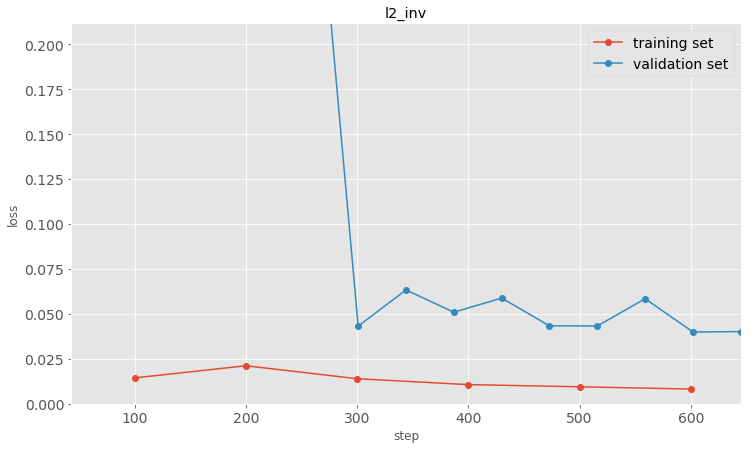

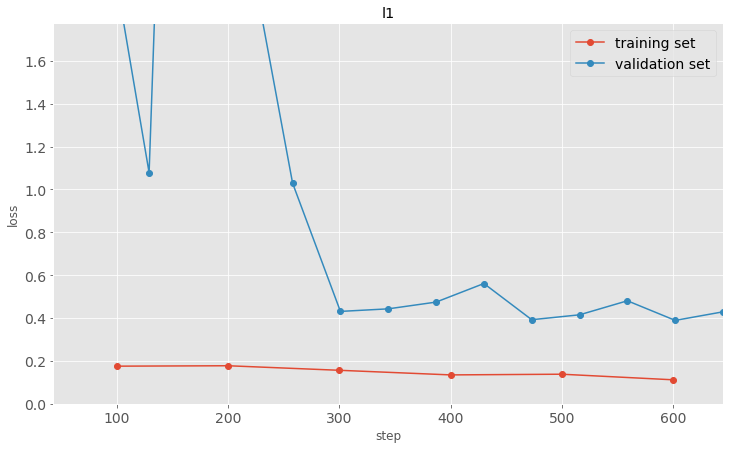

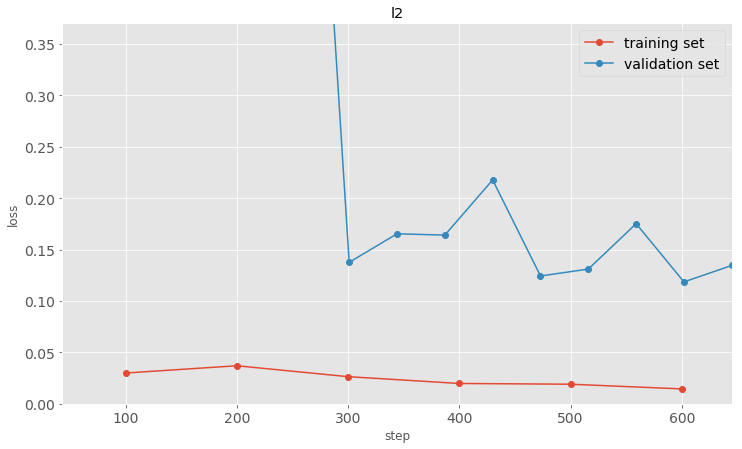

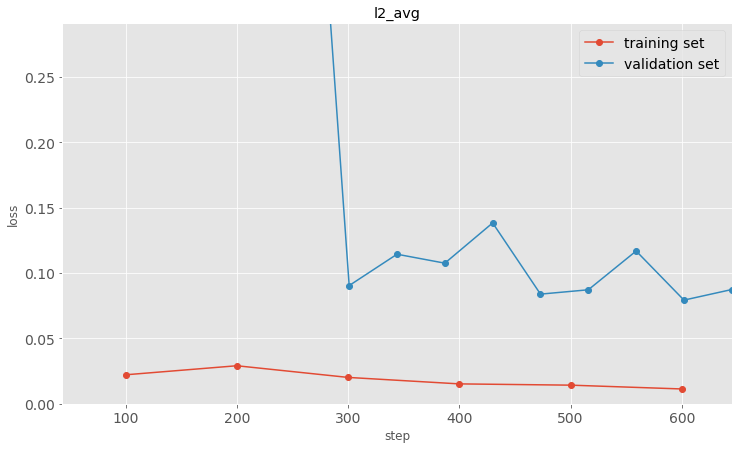

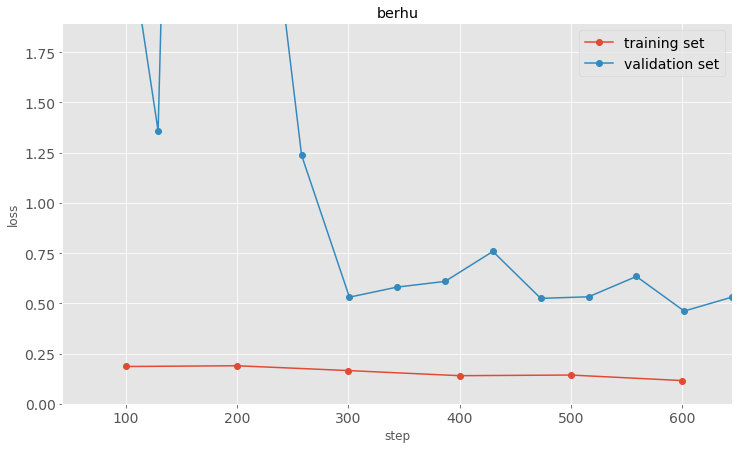

In [13]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_resnet_v1_50_narihira2015')
dfs_train_resnet_v1_50_narihira2015, dfs_valid_resnet_v1_50_narihira2015 = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_narihira2015,
                 dfdict_valid=dfs_valid_resnet_v1_50_narihira2015)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_narihira2015, 
                    dfs_valid=dfs_valid_resnet_v1_50_narihira2015, 
                    logy=False, ylim_scale=10)

## Resnet-50 deconv decoder (1 scale):

Training loss:
df_l2_inv (step: 6300): 0.00388 <-> corresponding valid loss: 0.02339 (step: 6321)
df_l1 (step: 7900): 0.06269 <-> corresponding valid loss: 0.29473 (step: 7912)
df_l2 (step: 6300): 0.00589 <-> corresponding valid loss: 0.06638 (step: 6321)
df_l2_avg (step: 6300): 0.00488 <-> corresponding valid loss: 0.04488 (step: 6321)
df_berhu (step: 7900): 0.06393 <-> corresponding valid loss: 0.33038 (step: 7912)

Validation loss:
df_l2_inv (step: 4085): 0.02283 <-> corresponding train loss: 0.00607 (step: 4100)
df_l1 (step: 8514): 0.27598 <-> corresponding train loss: 0.07868 (step: 8500)
df_l2 (step: 8514): 0.06334 <-> corresponding train loss: 0.00855 (step: 8500)
df_l2_avg (step: 8514): 0.04343 <-> corresponding train loss: 0.00700 (step: 8500)
df_berhu (step: 8514): 0.30342 <-> corresponding train loss: 0.08040 (step: 8500)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


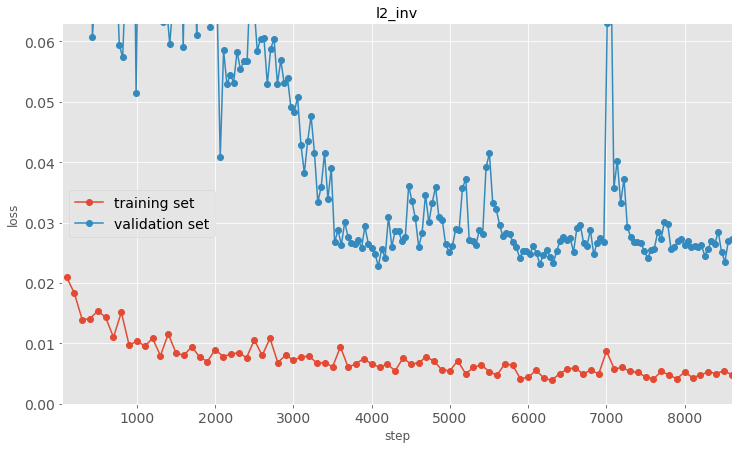

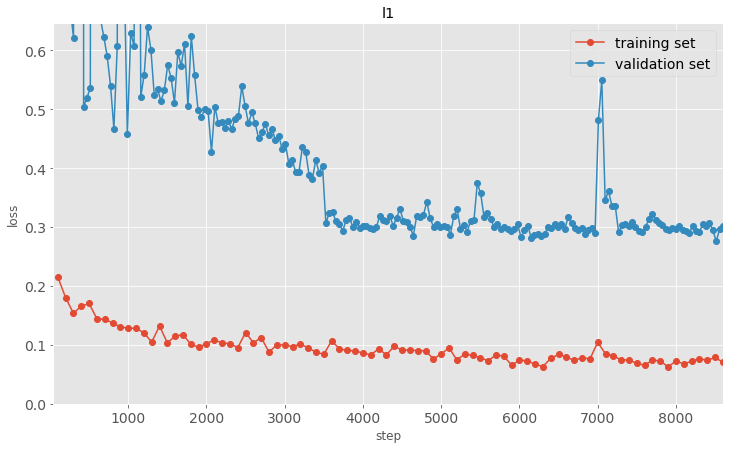

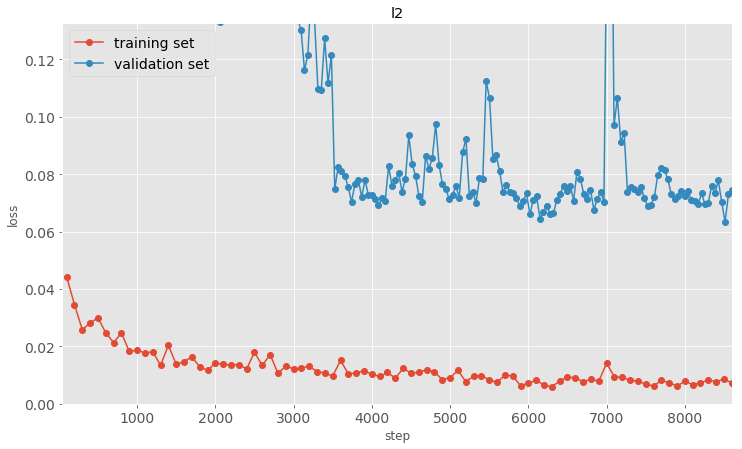

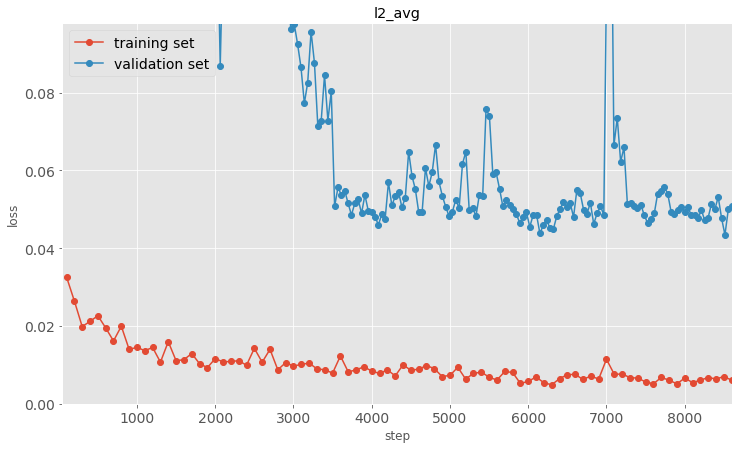

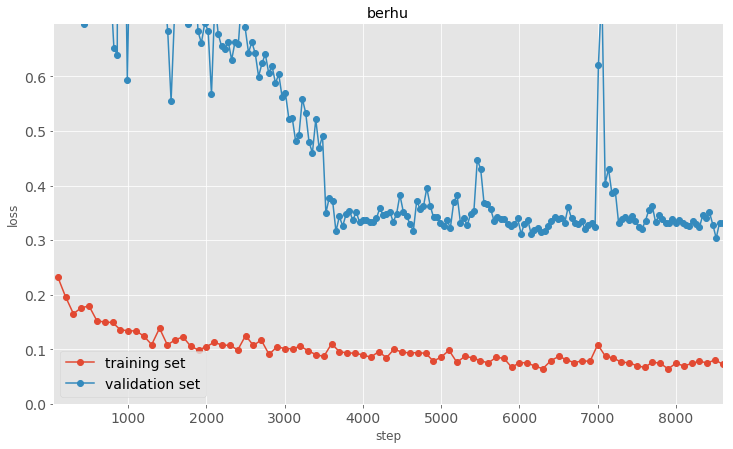

In [14]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_resnet_v1_50_deconv_decoder')
dfs_train_resnet_v1_50_deconv_decoder, dfs_valid_resnet_v1_50_deconv_decoder = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_deconv_decoder,
                 dfdict_valid=dfs_valid_resnet_v1_50_deconv_decoder)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_deconv_decoder, 
                    dfs_valid=dfs_valid_resnet_v1_50_deconv_decoder, logy=False, ylim_scale=3)

## VGG-16 Narihira2015 (2 scale):

Training loss:
df_l2_inv (step: 8400): 0.00265 <-> corresponding valid loss: 0.02773 (step: 8385)
df_l1 (step: 8400): 0.05335 <-> corresponding valid loss: 0.30025 (step: 8385)
df_l2 (step: 8400): 0.00407 <-> corresponding valid loss: 0.07606 (step: 8385)
df_l2_avg (step: 8400): 0.00336 <-> corresponding valid loss: 0.05189 (step: 8385)
df_berhu (step: 8400): 0.05397 <-> corresponding valid loss: 0.34866 (step: 8385)

Validation loss:
df_l2_inv (step: 1677): 0.02308 <-> corresponding train loss: 0.00828 (step: 1700)
df_l1 (step: 1677): 0.28213 <-> corresponding train loss: 0.11423 (step: 1700)
df_l2 (step: 1677): 0.06628 <-> corresponding train loss: 0.01483 (step: 1700)
df_l2_avg (step: 1677): 0.04468 <-> corresponding train loss: 0.01155 (step: 1700)
df_berhu (step: 1677): 0.31713 <-> corresponding train loss: 0.11793 (step: 1700)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


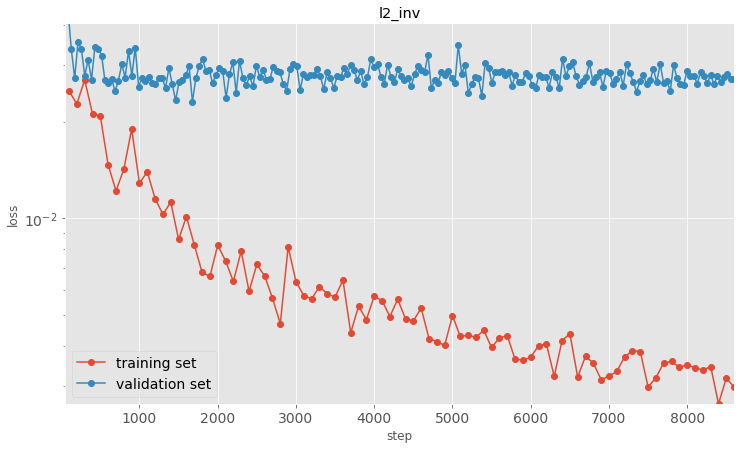

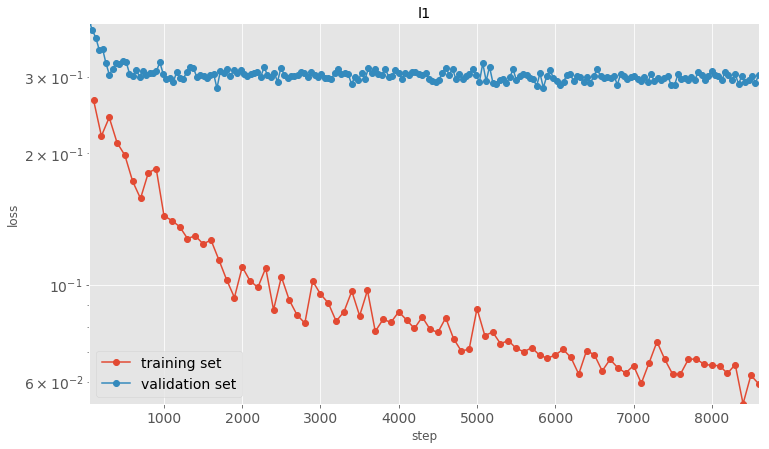

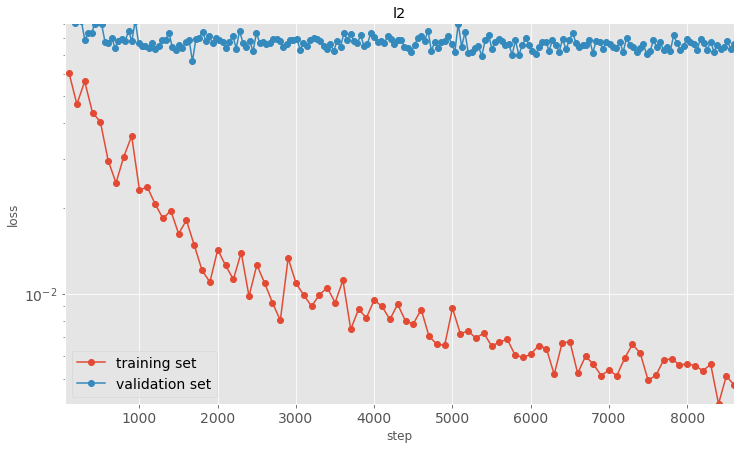

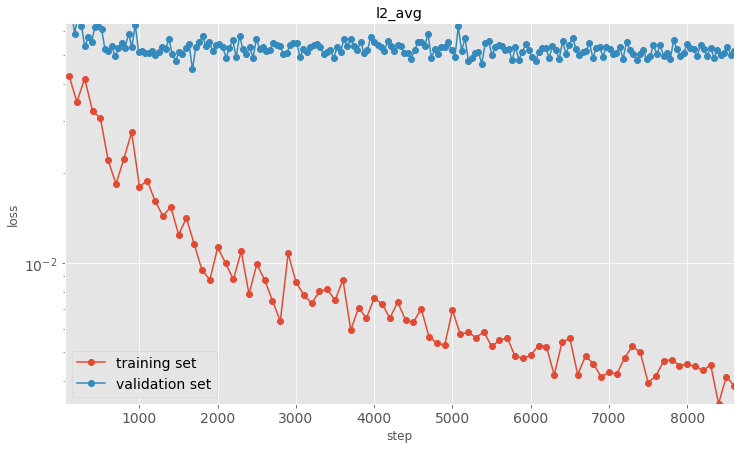

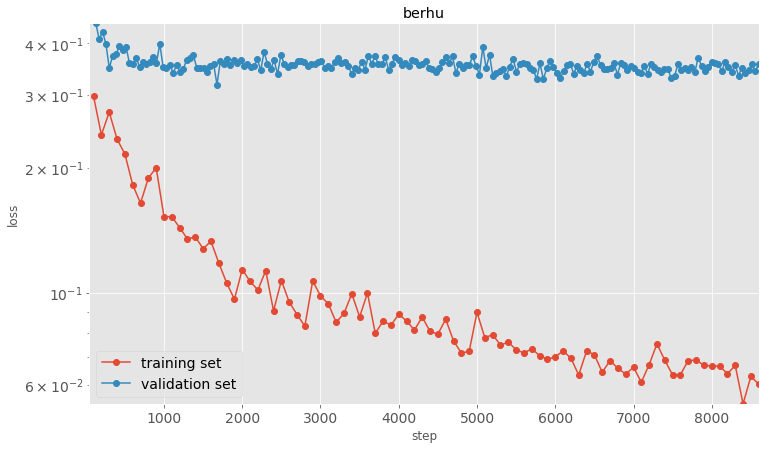

In [15]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_vgg16_narihira2015')
dfs_train_vgg16_narihira2015, dfs_valid_vgg16_narihira2015 = lst

get_minimum_loss(dfdict_train=dfs_train_vgg16_narihira2015,
                 dfdict_valid=dfs_valid_vgg16_narihira2015)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_narihira2015, 
                    dfs_valid=dfs_valid_vgg16_narihira2015, 
                    logy=True, ylim_scale=1.5)

## VGG-16 deconv_decoder (1 scale):

Training loss:
df_l2_inv (step: 3900): 0.00714 <-> corresponding valid loss: 0.02797 (step: 3913)
df_l1 (step: 4300): 0.09377 <-> corresponding valid loss: 0.30771 (step: 4300)
df_l2 (step: 3900): 0.01164 <-> corresponding valid loss: 0.07764 (step: 3913)
df_l2_avg (step: 3900): 0.00939 <-> corresponding valid loss: 0.05281 (step: 3913)
df_berhu (step: 4200): 0.09723 <-> corresponding valid loss: 0.36274 (step: 4214)

Validation loss:
df_l2_inv (step: 2193): 0.02521 <-> corresponding train loss: 0.01024 (step: 2200)
df_l1 (step: 3956): 0.29708 <-> corresponding train loss: 0.09580 (step: 4000)
df_l2 (step: 3956): 0.07398 <-> corresponding train loss: 0.01184 (step: 4000)
df_l2_avg (step: 3999): 0.05010 <-> corresponding train loss: 0.00954 (step: 4000)
df_berhu (step: 3655): 0.33850 <-> corresponding train loss: 0.10222 (step: 3700)


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


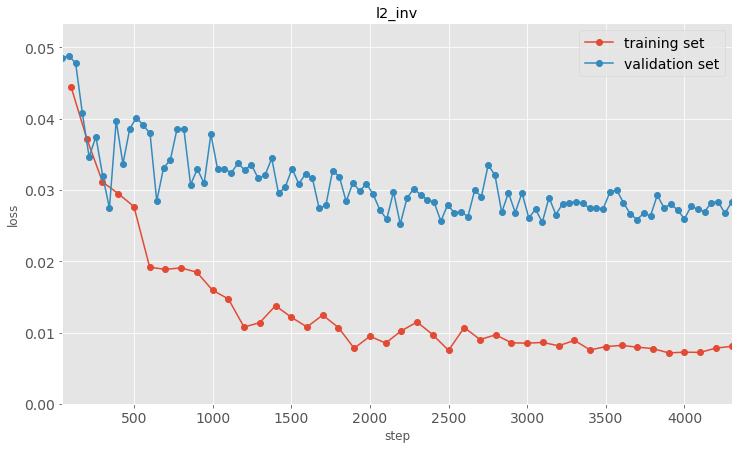

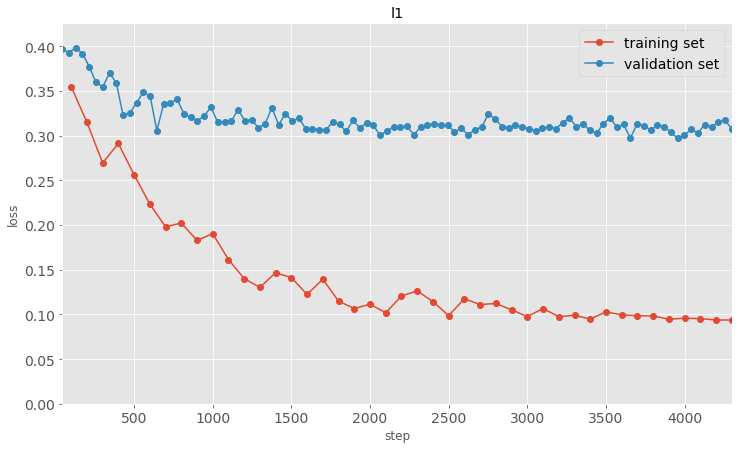

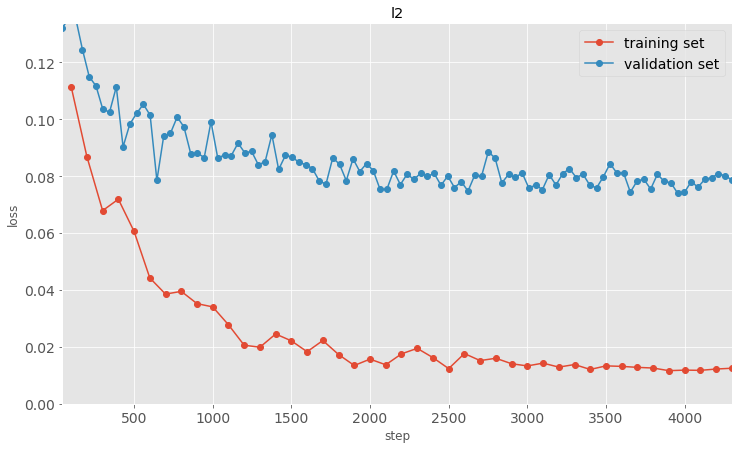

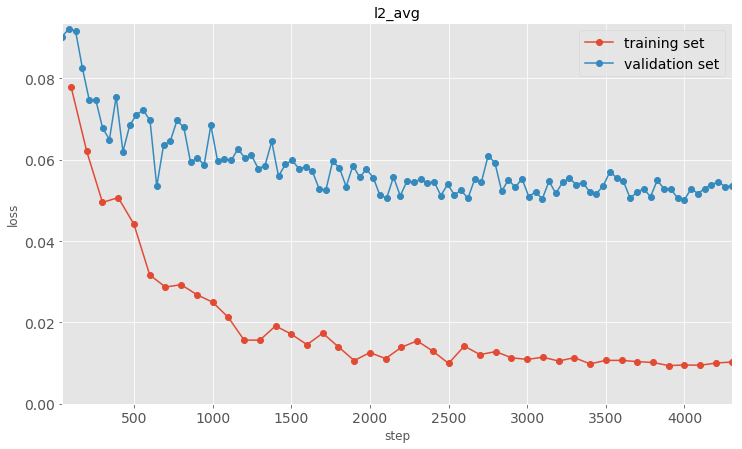

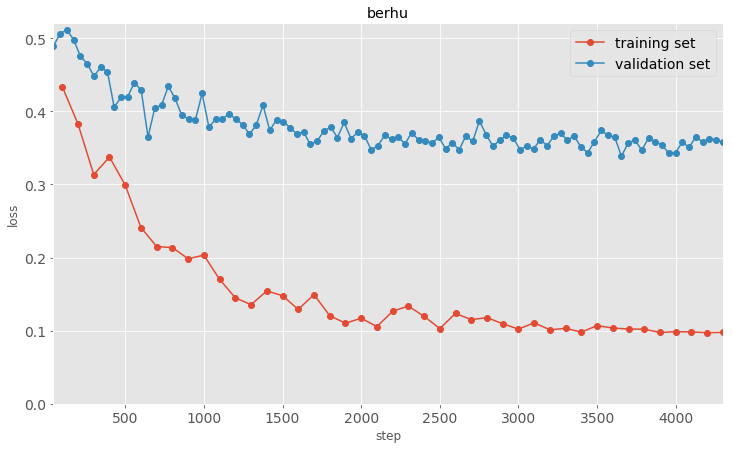

In [16]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_vgg16_deconv_decoder')
dfs_train_vgg16_deconv_decoder, dfs_valid_vgg16_deconv_decoder = lst

get_minimum_loss(dfdict_train=dfs_train_vgg16_deconv_decoder,
                 dfdict_valid=dfs_valid_vgg16_deconv_decoder)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_deconv_decoder, 
                    dfs_valid=dfs_valid_vgg16_deconv_decoder, 
                    logy=False, ylim_scale=1.2)

# IIW

In [17]:
logs_data_path_iiw = logs_data_path + 'iiw/'

## Resnet-50 narihira2015 (2 scale, reduced parameters):
### lambda = 1.0 (mhdl) (based on deleted sintel model)

Training loss:
df_l2_mwhdl (step: 9100): 0.49345 <-> corresponding valid loss: 0.61826 (step: 9136)
df_l1_mhdl (step: 9200): 0.79556 <-> corresponding valid loss: 0.91885 (step: 9136)
df_l2 (step: 7700): 0.00223 <-> corresponding valid loss: 0.00881 (step: 7672)
df_mwhdl (step: 9100): 0.49050 <-> corresponding valid loss: 0.61459 (step: 9136)
df_mhdl (step: 9200): 0.75899 <-> corresponding valid loss: 0.87698 (step: 9136)
df_l1 (step: 7700): 0.03112 <-> corresponding valid loss: 0.06270 (step: 7672)
df_l2_mhdl (step: 9200): 0.76194 <-> corresponding valid loss: 0.88065 (step: 9136)
df_l1_mwhdl (step: 9100): 0.52798 <-> corresponding valid loss: 0.65647 (step: 9136)

Validation loss:
df_l2_mwhdl (step: 8648): 0.61820 <-> corresponding train loss: 0.54961 (step: 8600)
df_l1_mhdl (step: 9136): 0.91885 <-> corresponding train loss: 0.81554 (step: 9100)
df_l2 (step: 9136): 0.00367 <-> corresponding train loss: 0.00295 (step: 9100)
df_mwhdl (step: 8648): 0.61422 <-> corresponding train loss:

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


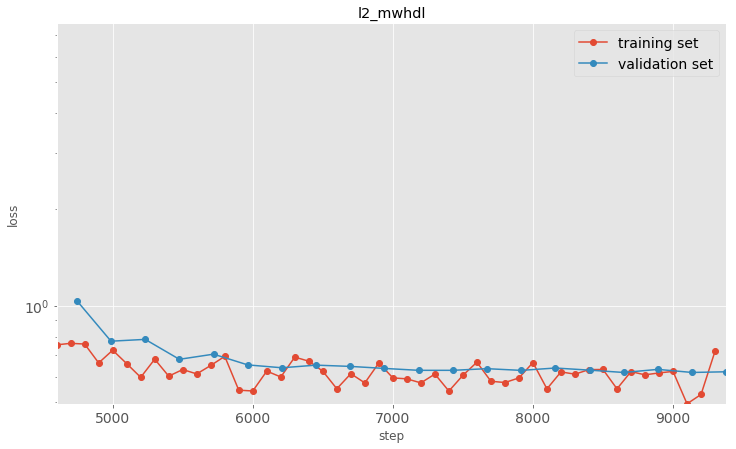

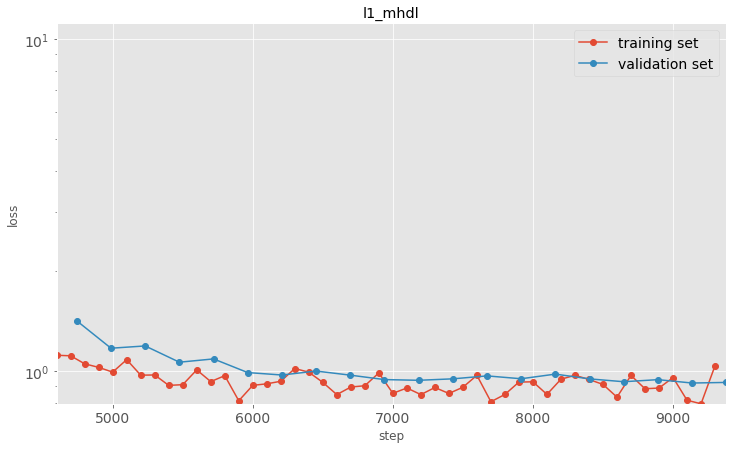

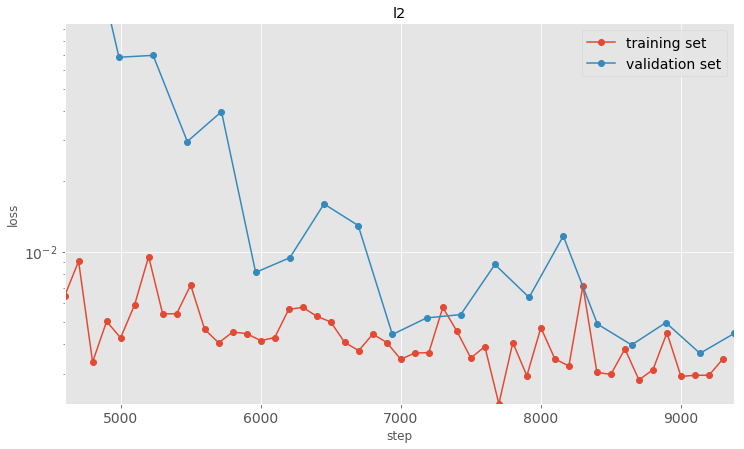

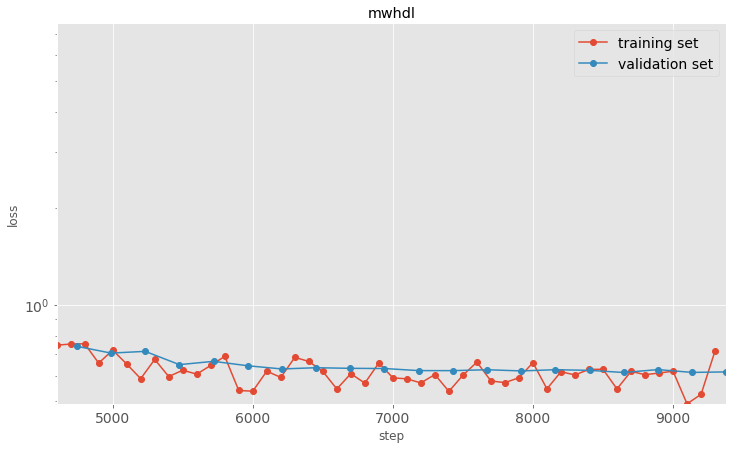

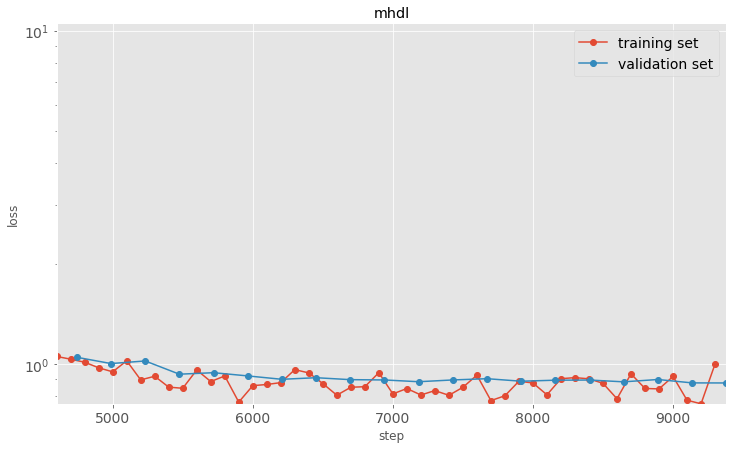

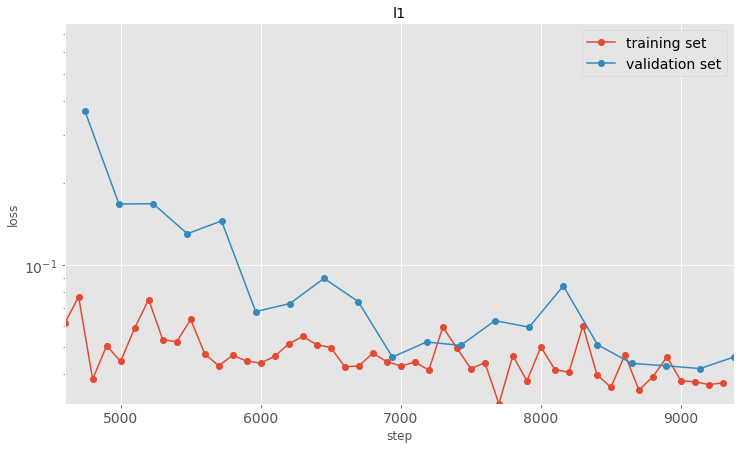

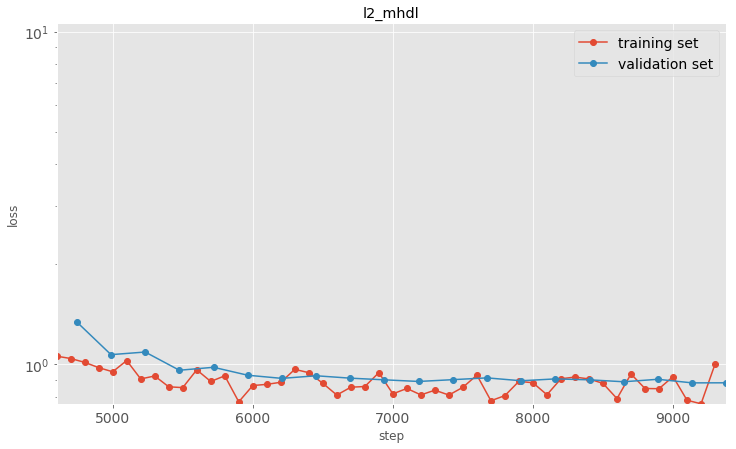

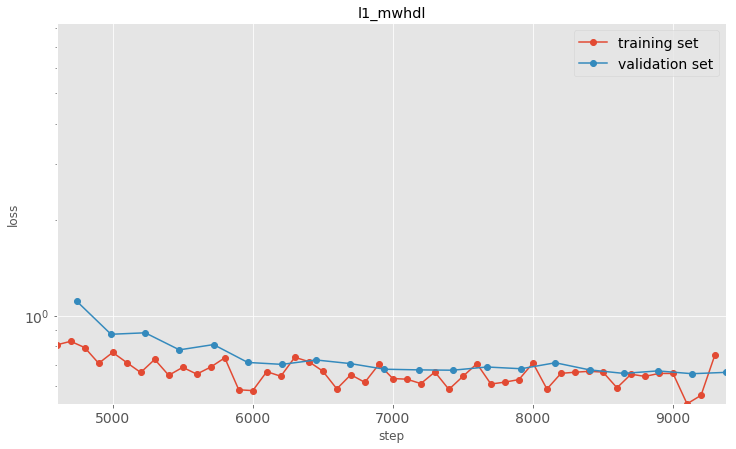

In [18]:
lst = get_all_loss_model_data(data_dir=logs_data_path_iiw + 'slim_resnet_v1_50_narihira2015_reduced/norm_l1_10mhdl')
dfs_train_iiw, dfs_valid_iiw = lst

get_minimum_loss(dfdict_train=dfs_train_iiw,
                 dfdict_valid=dfs_valid_iiw)

plot_all_loss_pairs(dfs_train=dfs_train_iiw, 
                    dfs_valid=dfs_valid_iiw, 
                    logy=True, ylim_scale=10)

### lambda = 0.1 (mhdl) (based on sintel model 4300)

Training loss:
df_l2_mwhdl (step: 4500): 0.06874 <-> corresponding valid loss: 0.17397 (step: 4544)
df_mhdl (step: 6300): 1.03650 <-> corresponding valid loss: 1.04492 (step: 6252)
df_l2 (step: 6400): 0.00221 <-> corresponding valid loss: 0.00822 (step: 6496)
df_mwhdl (step: 4500): 0.62540 <-> corresponding valid loss: 0.76414 (step: 4544)
df_l1_mhdl (step: 6400): 0.13472 <-> corresponding valid loss: 0.16879 (step: 6496)
df_l1 (step: 6400): 0.03051 <-> corresponding valid loss: 0.06458 (step: 6496)
df_l2_mhdl (step: 5400): 0.10606 <-> corresponding valid loss: 0.11128 (step: 5520)
df_l1_mwhdl (step: 5400): 0.10426 <-> corresponding valid loss: 0.12621 (step: 5520)

Validation loss:
df_l2_mwhdl (step: 6252): 0.07736 <-> corresponding train loss: 0.08302 (step: 6300)
df_mhdl (step: 6740): 1.03749 <-> corresponding train loss: 1.04908 (step: 6700)
df_l2 (step: 6252): 0.00286 <-> corresponding train loss: 0.00344 (step: 6300)
df_mwhdl (step: 6496): 0.73807 <-> corresponding train loss: 0.

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


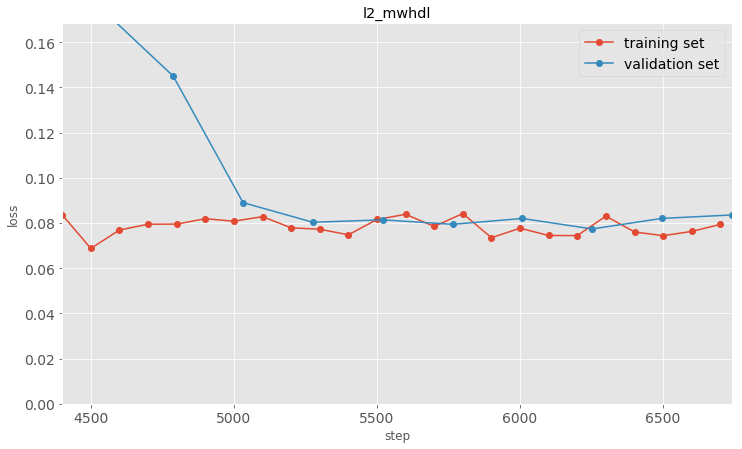

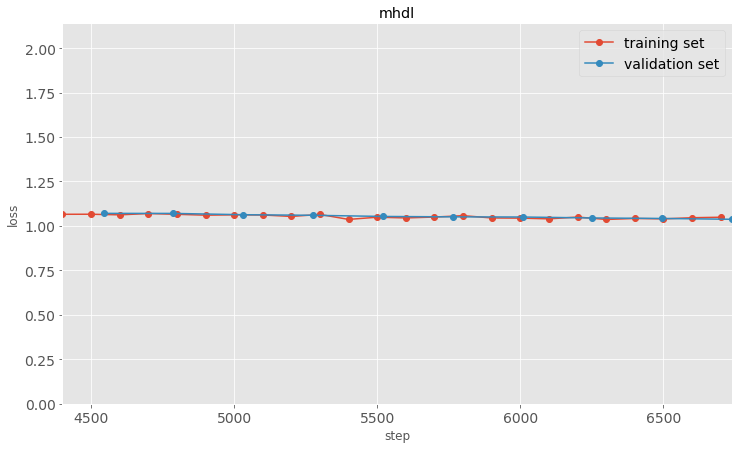

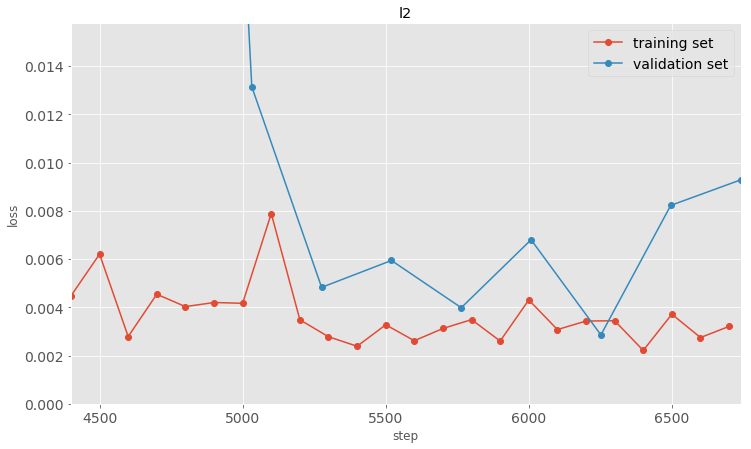

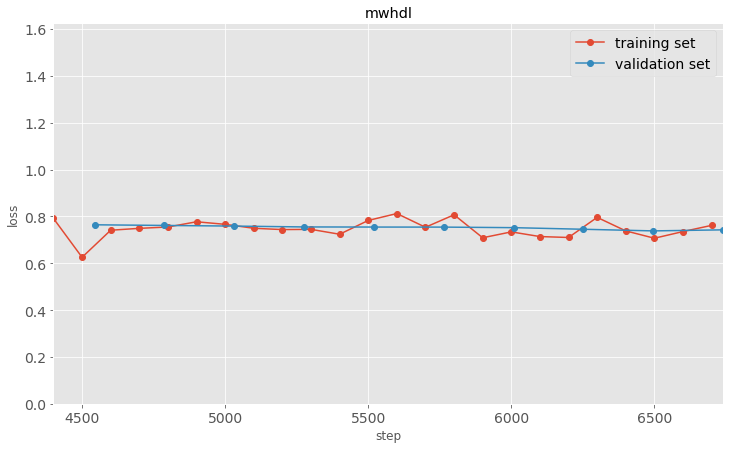

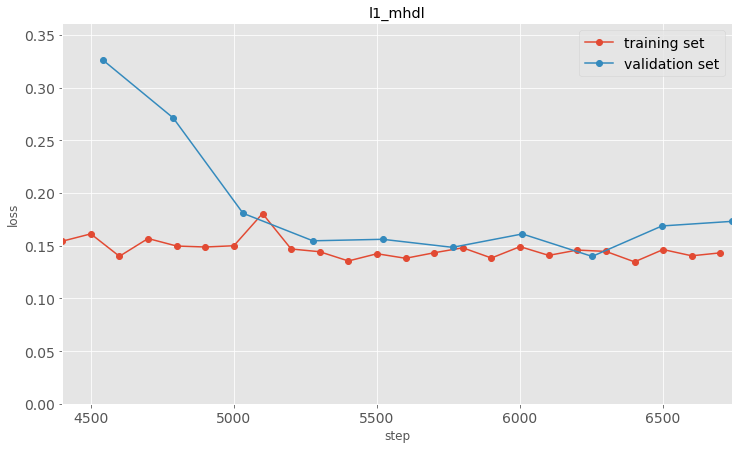

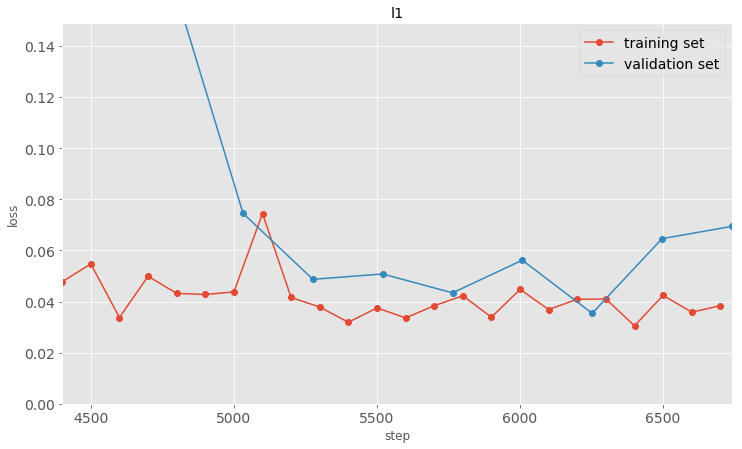

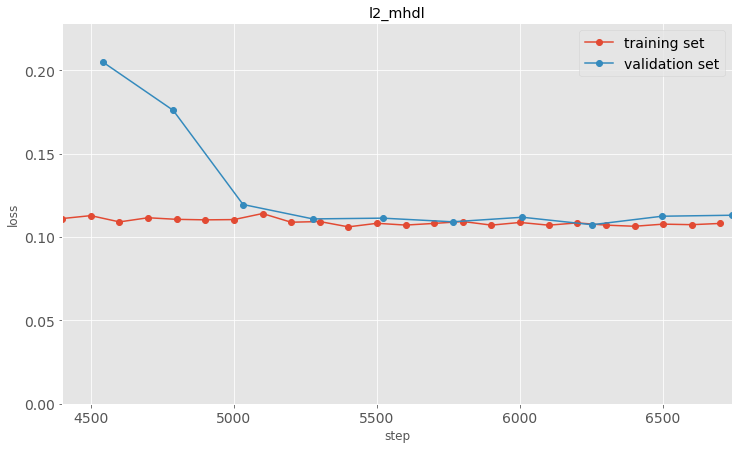

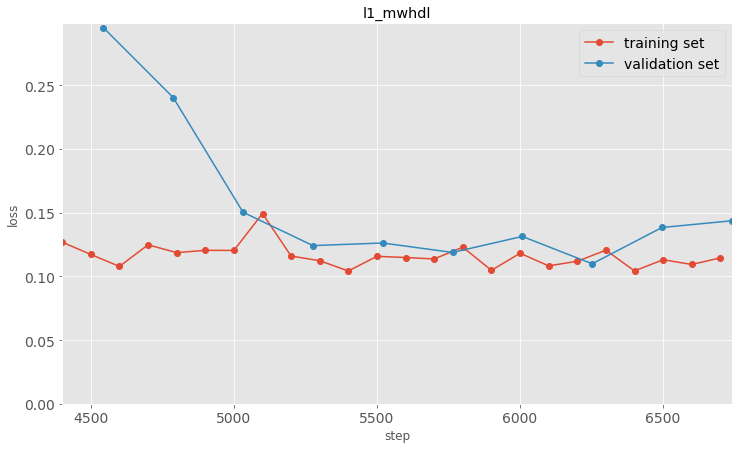

In [19]:
lst = get_all_loss_model_data(data_dir=logs_data_path_iiw + 'slim_resnet_v1_50_narihira2015_reduced/norm_l1_01mhdl')
dfs_train_iiw, dfs_valid_iiw = lst

get_minimum_loss(dfdict_train=dfs_train_iiw,
                 dfdict_valid=dfs_valid_iiw)

plot_all_loss_pairs(dfs_train=dfs_train_iiw, 
                    dfs_valid=dfs_valid_iiw, 
                    logy=False, ylim_scale=2)

### lambda = 0.1 (mwhdl) (based on sintel model 4300)

Training loss:
df_l2_mwhdl (step: 6700): 0.07175 <-> corresponding valid loss: 0.07810 (step: 6740)
df_mhdl (step: 6600): 1.03854 <-> corresponding valid loss: 1.05562 (step: 6496)
df_l2 (step: 6300): 0.00205 <-> corresponding valid loss: 0.00448 (step: 6252)
df_mwhdl (step: 6700): 0.68168 <-> corresponding valid loss: 0.74470 (step: 6740)
df_l1_mhdl (step: 6300): 0.13545 <-> corresponding valid loss: 0.15275 (step: 6252)
df_l1 (step: 6300): 0.02932 <-> corresponding valid loss: 0.04759 (step: 6252)
df_l2_mhdl (step: 6600): 0.10718 <-> corresponding valid loss: 0.11498 (step: 6496)
df_l1_mwhdl (step: 5900): 0.10568 <-> corresponding valid loss: 0.15703 (step: 6008)

Validation loss:
df_l2_mwhdl (step: 6740): 0.07810 <-> corresponding train loss: 0.07175 (step: 6700)
df_mhdl (step: 6740): 1.05007 <-> corresponding train loss: 1.05548 (step: 6700)
df_l2 (step: 6740): 0.00363 <-> corresponding train loss: 0.00358 (step: 6700)
df_mwhdl (step: 6740): 0.74470 <-> corresponding train loss: 0.

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


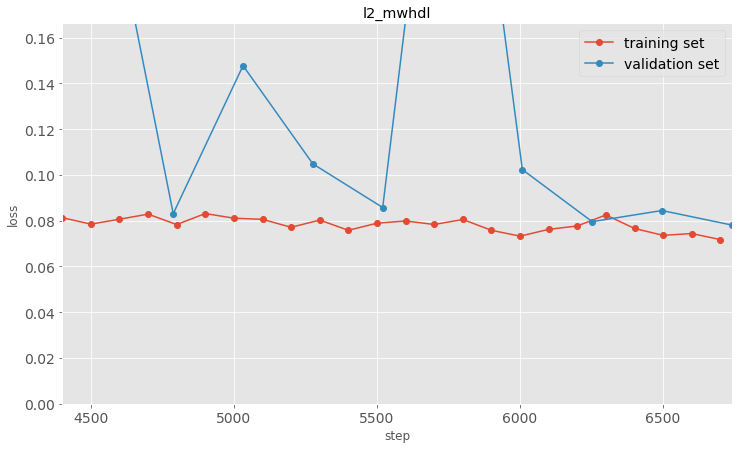

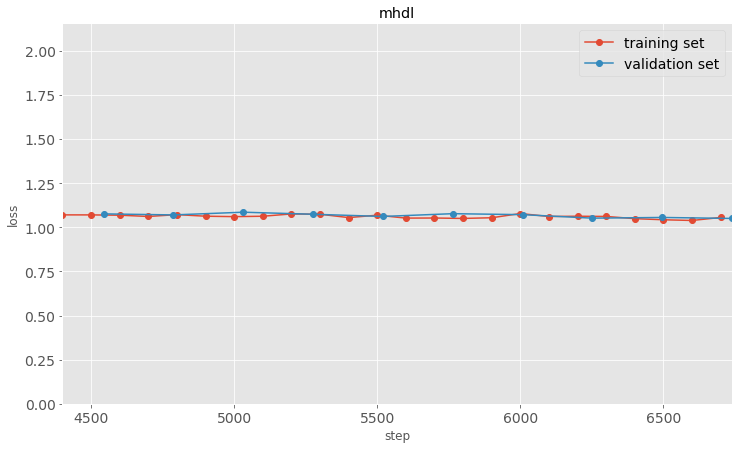

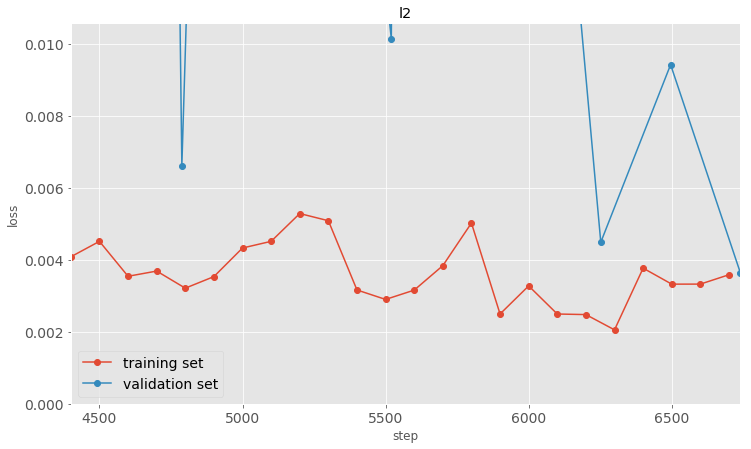

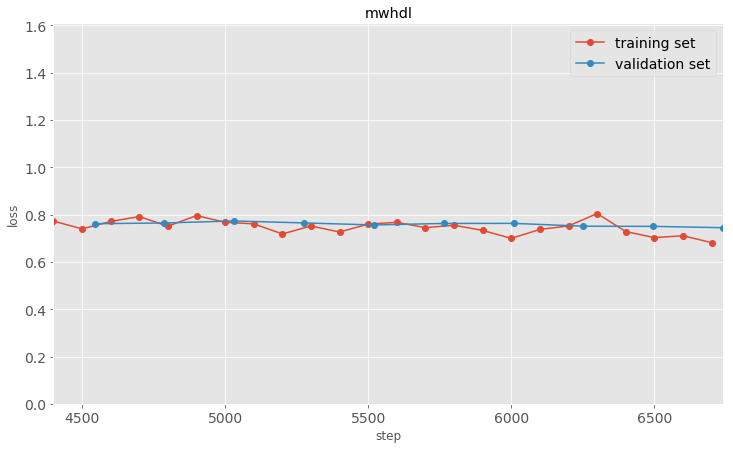

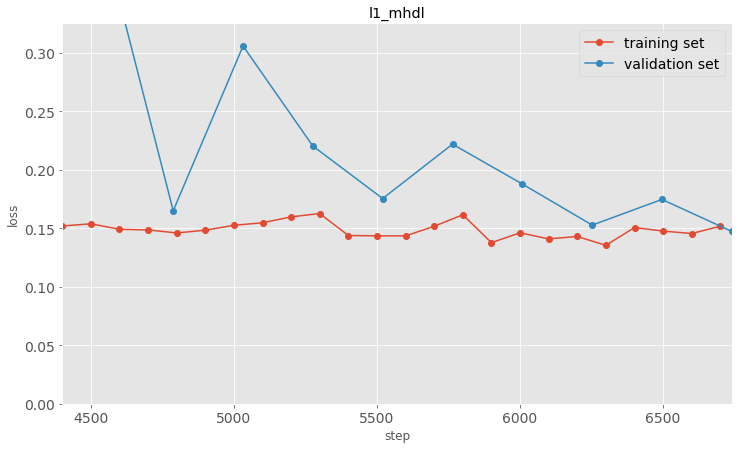

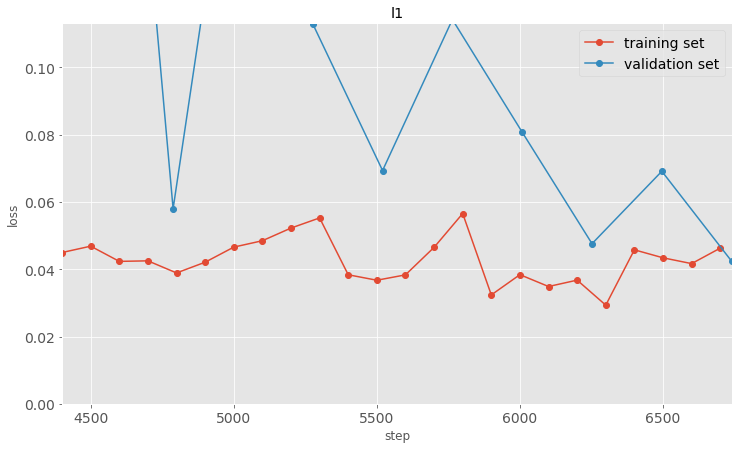

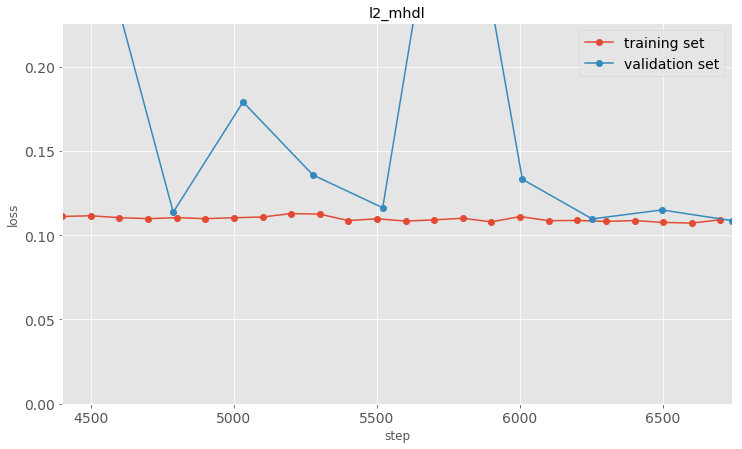

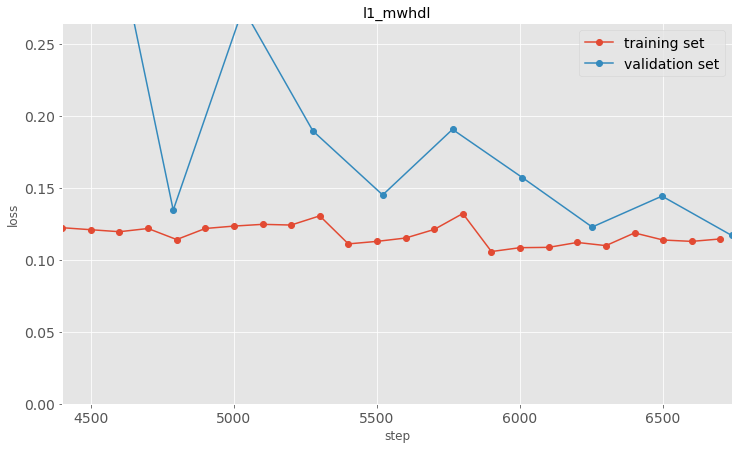

In [22]:
lst = get_all_loss_model_data(data_dir=logs_data_path_iiw + 'slim_resnet_v1_50_narihira2015_reduced/norm_l1_01mwhdl')
dfs_train_iiw, dfs_valid_iiw = lst

get_minimum_loss(dfdict_train=dfs_train_iiw,
                 dfdict_valid=dfs_valid_iiw)

plot_all_loss_pairs(dfs_train=dfs_train_iiw, 
                    dfs_valid=dfs_valid_iiw, 
                    logy=False, ylim_scale=2)

## Resnet-50 deconv decoder (1 scale):
### lambda = 0.5 (mhdl)

Training loss:
df_l1 (step: 7900): 0.06149 <-> corresponding valid loss: 0.27628 (step: 8008)
df_l2 (step: 7900): 0.00910 <-> corresponding valid loss: 0.98829 (step: 8008)
df_mhdl (step: 7900): 0.79521 <-> corresponding valid loss: 1.09133 (step: 8008)
df_l1_mwhdl (step: 8400): 0.33305 <-> corresponding valid loss: 0.64022 (step: 8496)
df_l2_mhdl (step: 7900): 0.40670 <-> corresponding valid loss: 1.53395 (step: 8008)
df_mwhdl (step: 8400): 0.53156 <-> corresponding valid loss: 0.73895 (step: 8496)
df_l1_mhdl (step: 7900): 0.45909 <-> corresponding valid loss: 0.82195 (step: 8008)
df_l2_mwhdl (step: 8400): 0.27652 <-> corresponding valid loss: 57.43792 (step: 8496)

Validation loss:
df_l1 (step: 8252): 0.10679 <-> corresponding train loss: 0.06644 (step: 8300)
df_l2 (step: 8252): 0.02159 <-> corresponding train loss: 0.00964 (step: 8300)
df_mhdl (step: 8740): 0.90667 <-> corresponding train loss: 0.96790 (step: 8700)
df_l1_mwhdl (step: 8252): 0.42849 <-> corresponding train loss: 0.36

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


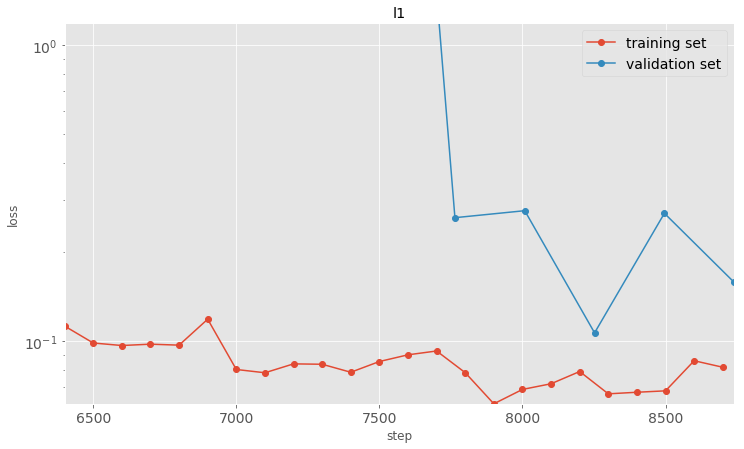

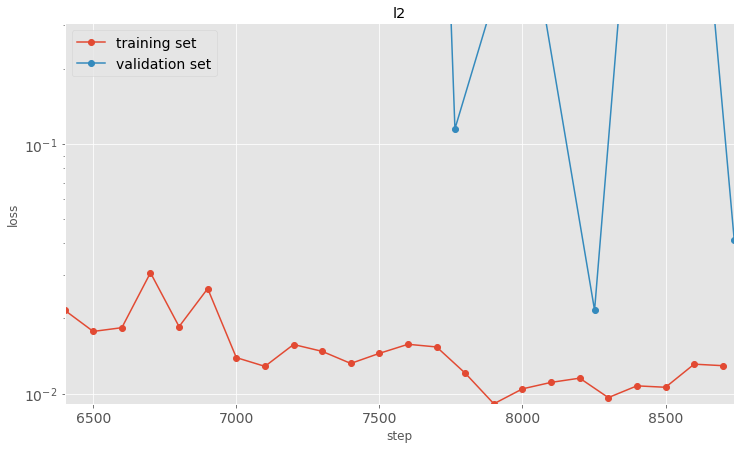

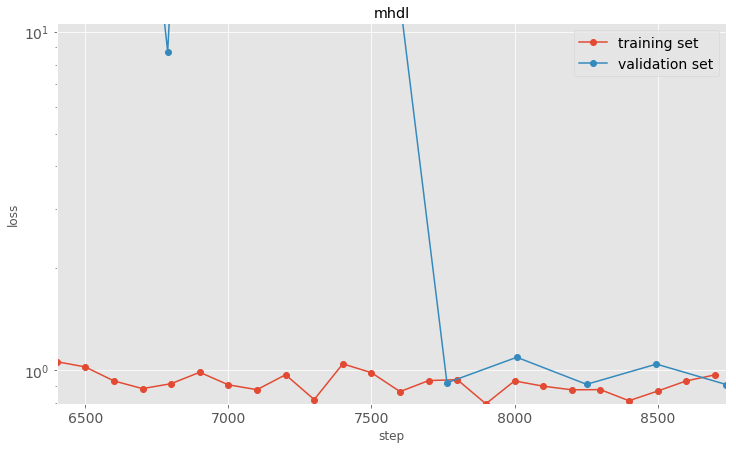

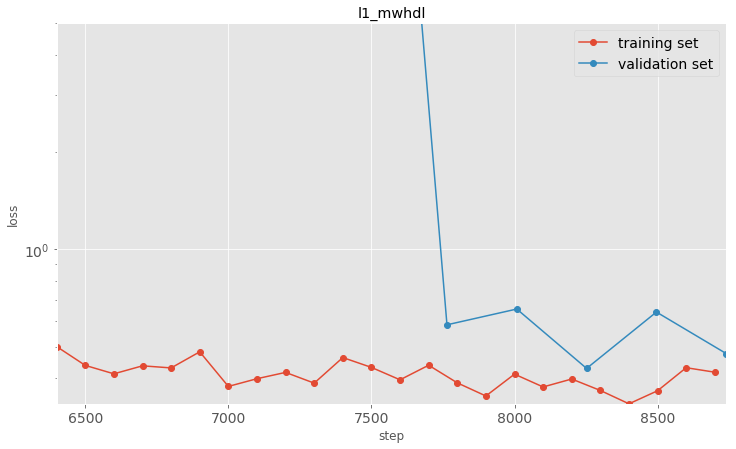

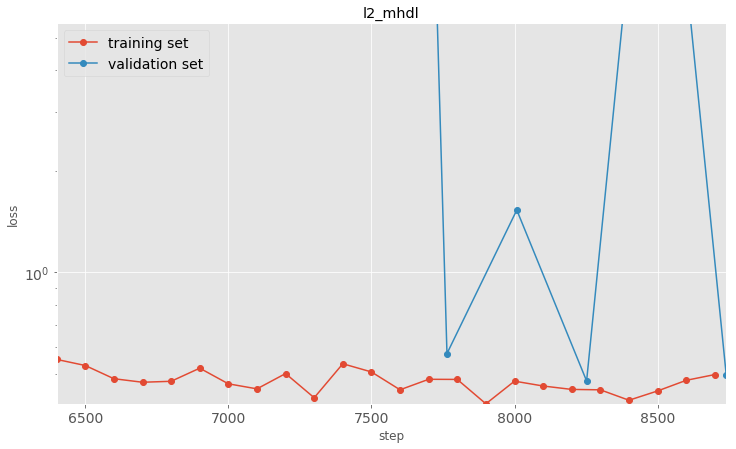

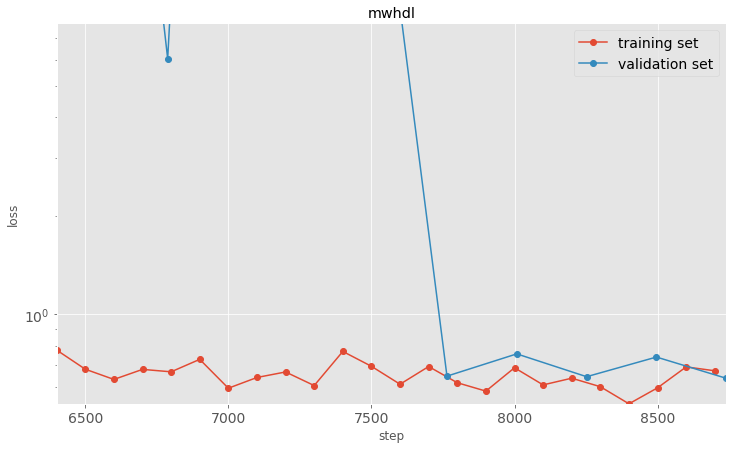

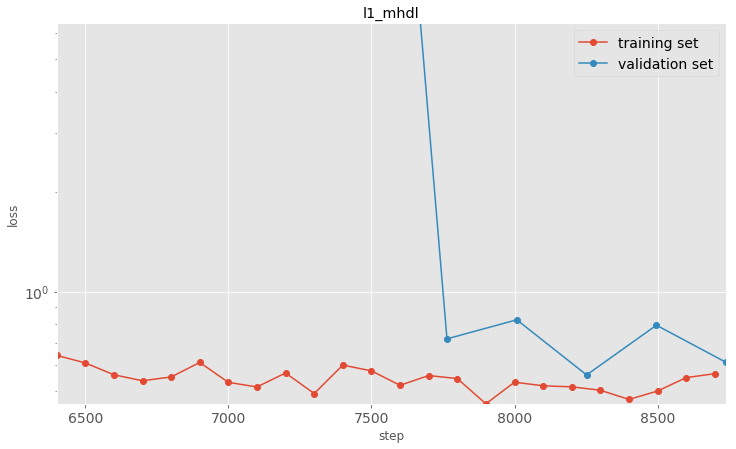

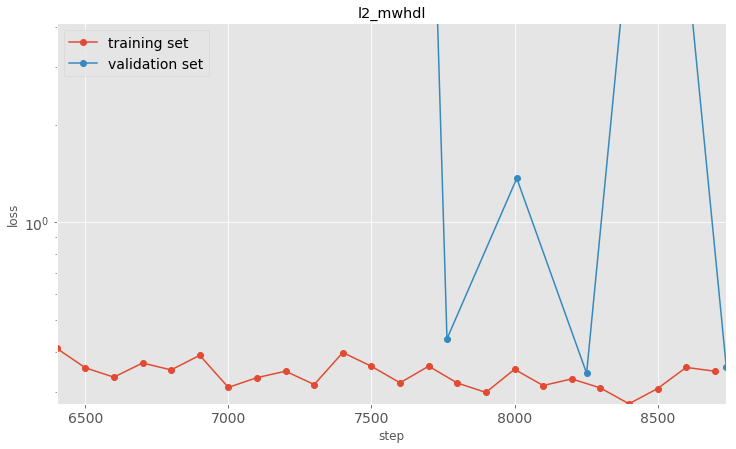

In [29]:
lst = get_all_loss_model_data(data_dir=logs_data_path_iiw + 'slim_resnet_v1_50_deconv_decoder/l1_05mhdl')
dfs_train_resnet_v1_50_deconv_decoder_iiw, dfs_valid_resnet_v1_50_deconv_decoder_iiw = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_deconv_decoder_iiw,
                 dfdict_valid=dfs_valid_resnet_v1_50_deconv_decoder_iiw)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_deconv_decoder_iiw, 
                    dfs_valid=dfs_valid_resnet_v1_50_deconv_decoder_iiw, 
                    logy=True, ylim_scale=10)

### lambda = 1.0 (mhdl)        

Training loss:
df_l1 (step: 8400): 0.05380 <-> corresponding valid loss: 0.07160 (step: 8496)
df_l2 (step: 8400): 0.00715 <-> corresponding valid loss: 0.05235 (step: 8496)
df_mhdl (step: 7700): 0.79028 <-> corresponding valid loss: 0.91040 (step: 7764)
df_l1_mwhdl (step: 8600): 0.60100 <-> corresponding valid loss: 0.69596 (step: 8496)
df_l2_mhdl (step: 7700): 0.80297 <-> corresponding valid loss: 0.93701 (step: 7764)
df_mwhdl (step: 8600): 0.53556 <-> corresponding valid loss: 0.62436 (step: 8496)
df_l1_mhdl (step: 7700): 0.85844 <-> corresponding valid loss: 1.02842 (step: 7764)
df_l2_mwhdl (step: 8600): 0.54650 <-> corresponding valid loss: 0.67670 (step: 8496)

Validation loss:
df_l1 (step: 8496): 0.07160 <-> corresponding train loss: 0.06060 (step: 8500)
df_l2 (step: 8252): 0.01380 <-> corresponding train loss: 0.01601 (step: 8300)
df_mhdl (step: 8496): 0.89498 <-> corresponding train loss: 0.92624 (step: 8500)
df_l1_mwhdl (step: 8496): 0.69596 <-> corresponding train loss: 0.716

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


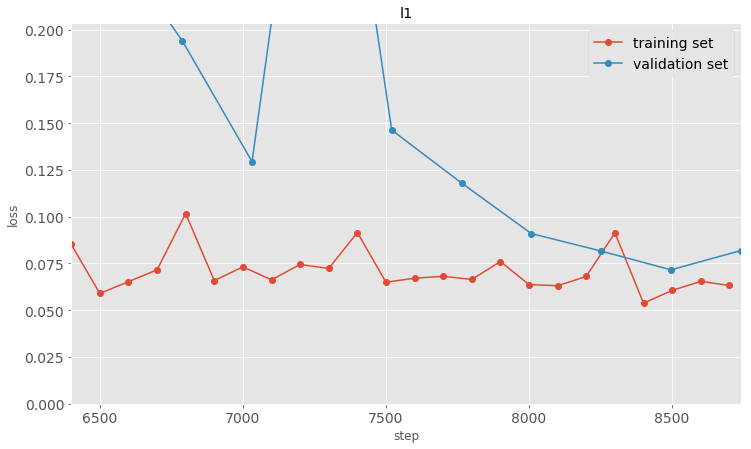

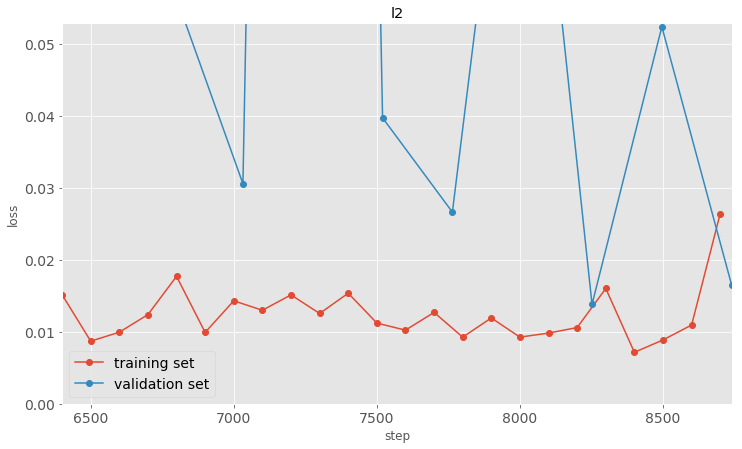

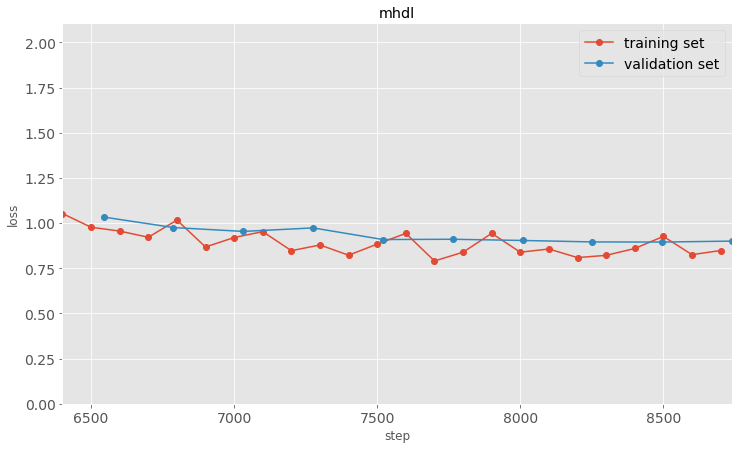

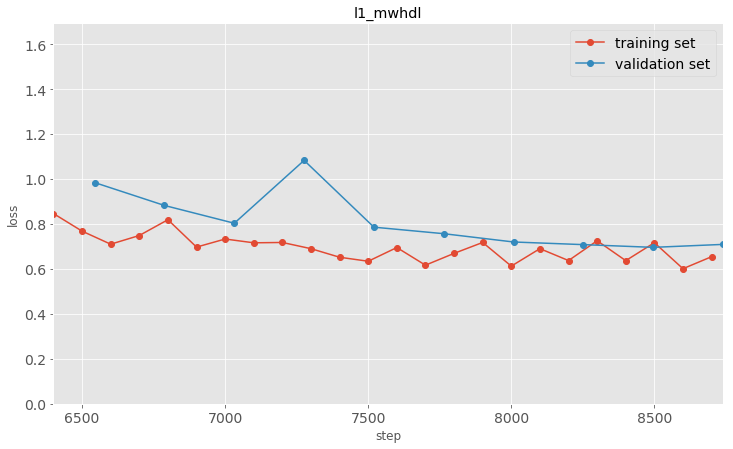

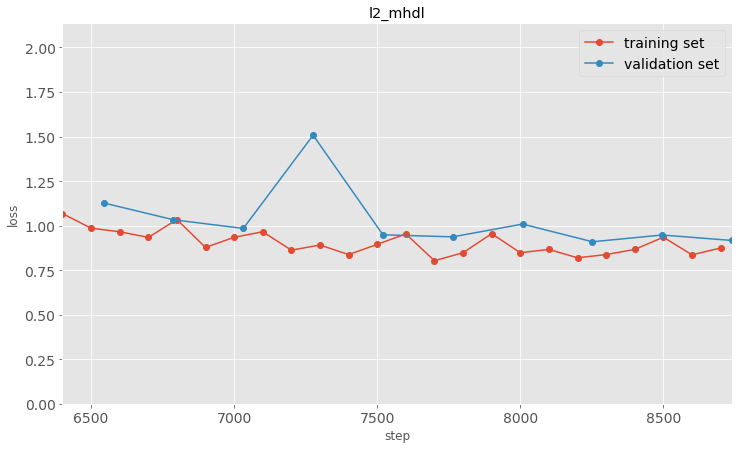

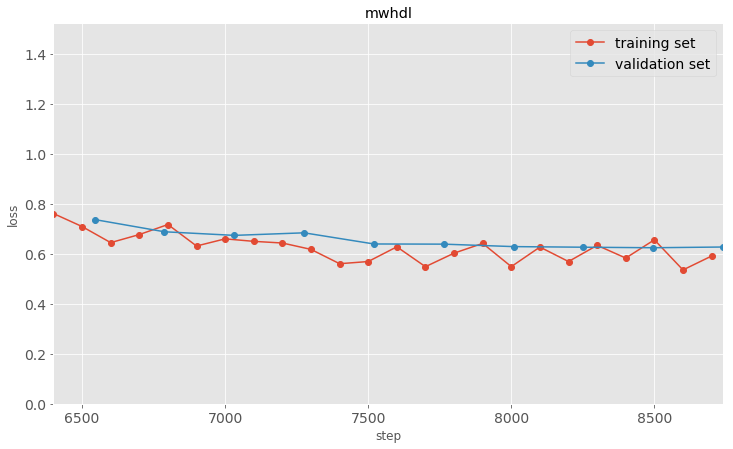

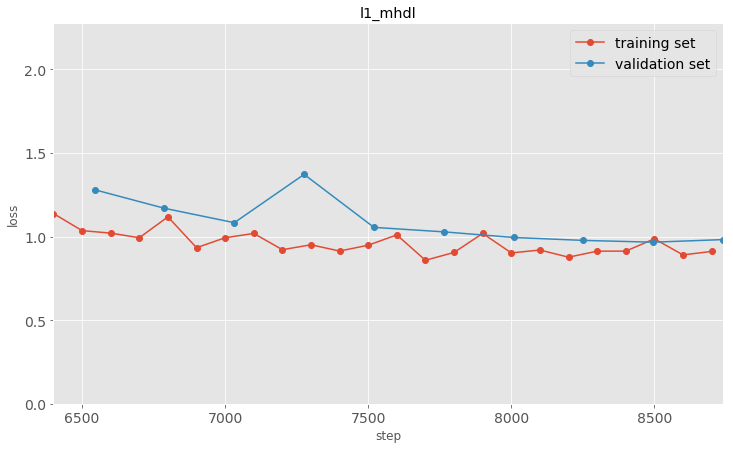

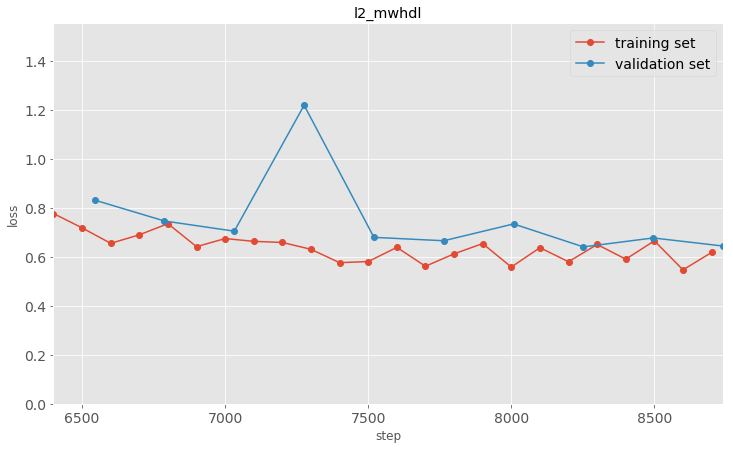

In [30]:
lst = get_all_loss_model_data(data_dir=logs_data_path_iiw + 'slim_resnet_v1_50_deconv_decoder/l1_10mhdl',
                              exclude_sub_dirs=['2'])
dfs_train_resnet_v1_50_deconv_decoder_iiw, dfs_valid_resnet_v1_50_deconv_decoder_iiw = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_deconv_decoder_iiw,
                 dfdict_valid=dfs_valid_resnet_v1_50_deconv_decoder_iiw)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_deconv_decoder_iiw, 
                    dfs_valid=dfs_valid_resnet_v1_50_deconv_decoder_iiw, 
                    logy=False, ylim_scale=2)

## vgg-16 narihira2015:

### lambda = 1.0 (mhdl)

Training loss:
df_l1 (step: 11500): 0.03229 <-> corresponding valid loss: 0.03840 (step: 11404)
df_l2 (step: 11500): 0.00250 <-> corresponding valid loss: 0.00351 (step: 11404)
df_mhdl (step: 11900): 0.77809 <-> corresponding valid loss: 0.89490 (step: 11892)
df_l1_mwhdl (step: 10600): 0.56677 <-> corresponding valid loss: 0.65285 (step: 10672)
df_l2_mhdl (step: 11900): 0.78126 <-> corresponding valid loss: 0.89805 (step: 11892)
df_mwhdl (step: 10600): 0.53061 <-> corresponding valid loss: 0.61567 (step: 10672)
df_l1_mhdl (step: 11900): 0.81410 <-> corresponding valid loss: 0.93022 (step: 11892)
df_l2_mwhdl (step: 10600): 0.53380 <-> corresponding valid loss: 0.61902 (step: 10672)

Validation loss:
df_l1 (step: 12380): 0.03531 <-> corresponding train loss: 0.03973 (step: 12300)
df_l2 (step: 12380): 0.00312 <-> corresponding train loss: 0.00392 (step: 12300)
df_mhdl (step: 12136): 0.87565 <-> corresponding train loss: 0.83274 (step: 12100)
df_l1_mwhdl (step: 12136): 0.65031 <-> correspo

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


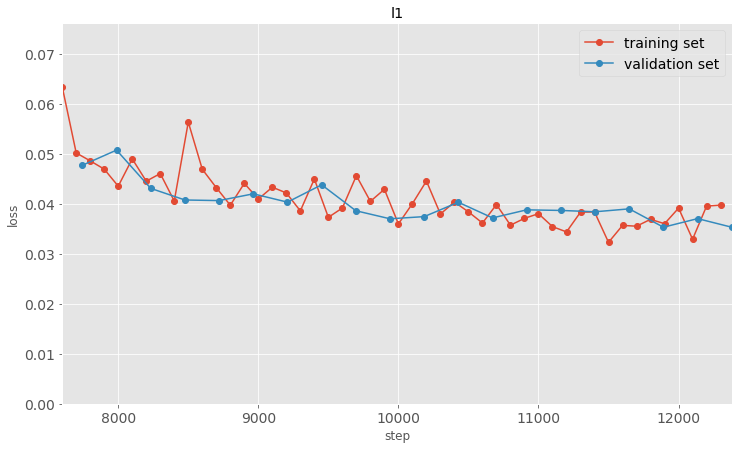

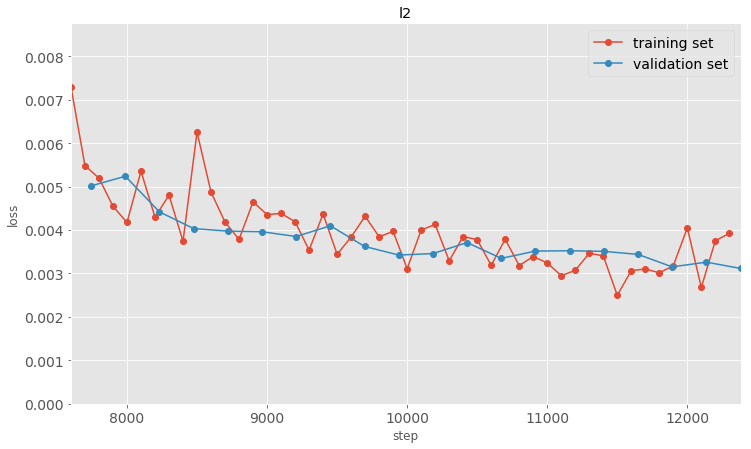

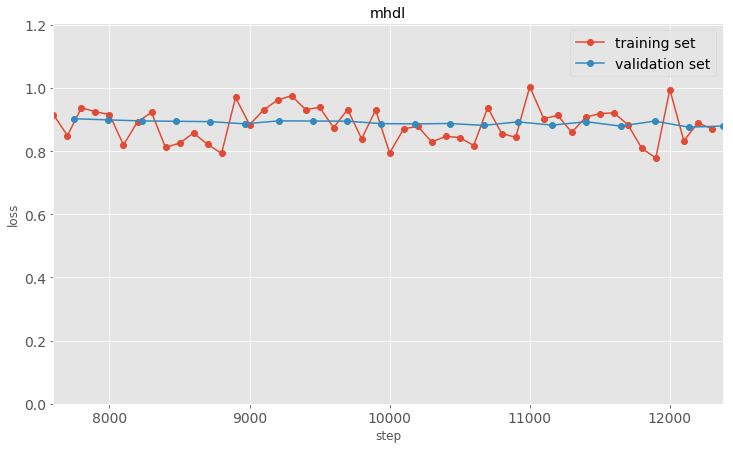

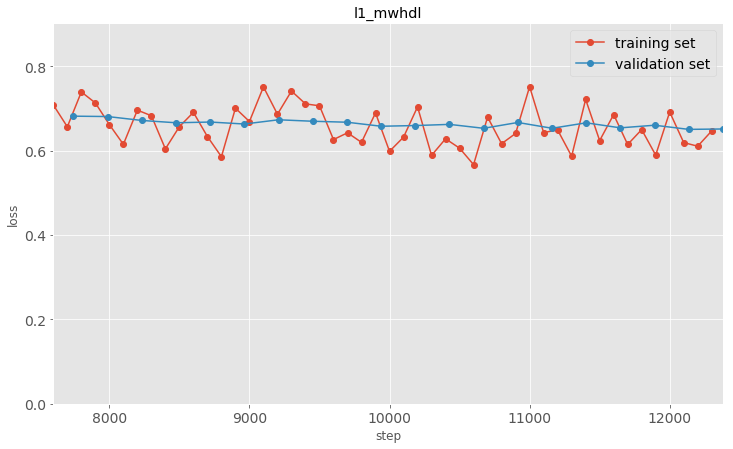

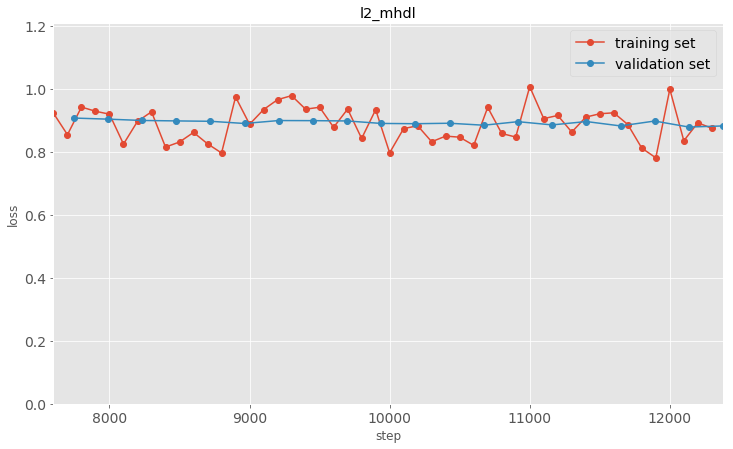

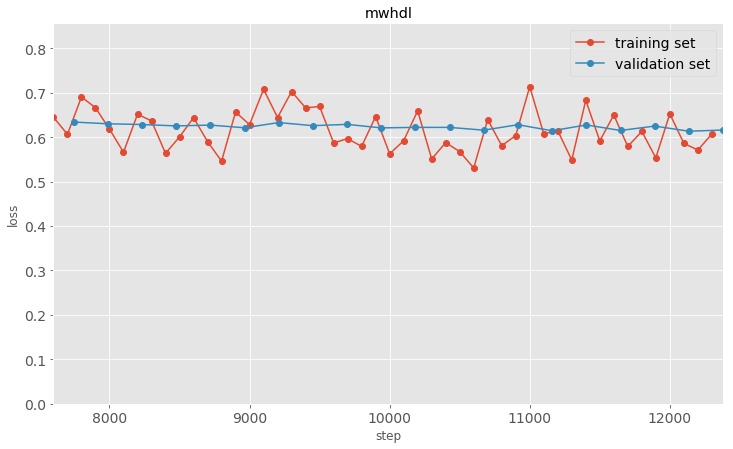

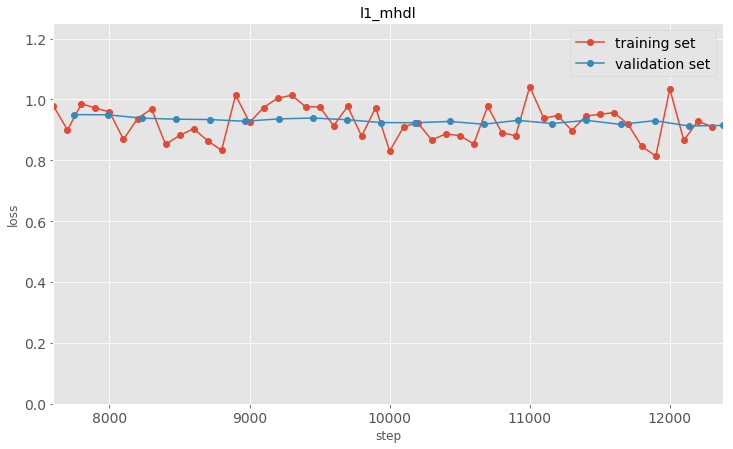

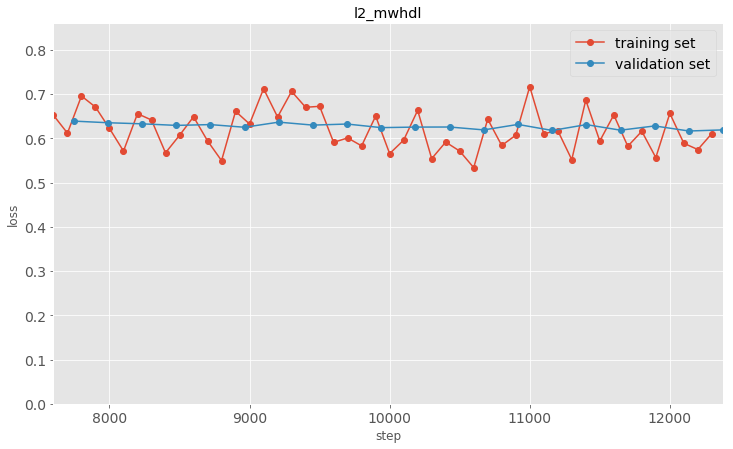

In [31]:
lst = get_all_loss_model_data(data_dir=logs_data_path_iiw + 'slim_vgg16_narihira2015/l1_10mhdl',
                              exclude_sub_dirs=['2'])
dfs_train_vgg16_narihira2015_iiw, dfs_valid_vgg16_narihira2015_iiw = lst

get_minimum_loss(dfdict_train=dfs_train_vgg16_narihira2015_iiw,
                 dfdict_valid=dfs_valid_vgg16_narihira2015_iiw)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_narihira2015_iiw, 
                    dfs_valid=dfs_valid_vgg16_narihira2015_iiw, 
                    logy=False, ylim_scale=1.2)